In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importar bibliotecas adicionales para pruebas estadísticas
from scipy import stats
from scipy.stats import shapiro, normaltest, levene, bartlett, chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/juancmacias/datas/main/DataSet/PhiUSIIL_Phishing_URL_Dataset.csv")
print(f"Dataset cargado correctamente. Dimensiones: {df.shape}")

Dataset cargado correctamente. Dimensiones: (235795, 56)



--- ANÁLISIS EXPLORATORIO MEJORADO Y PRUEBAS PARAMÉTRICAS ---

1. Análisis univariado detallado

Columna objetivo (asumida): label


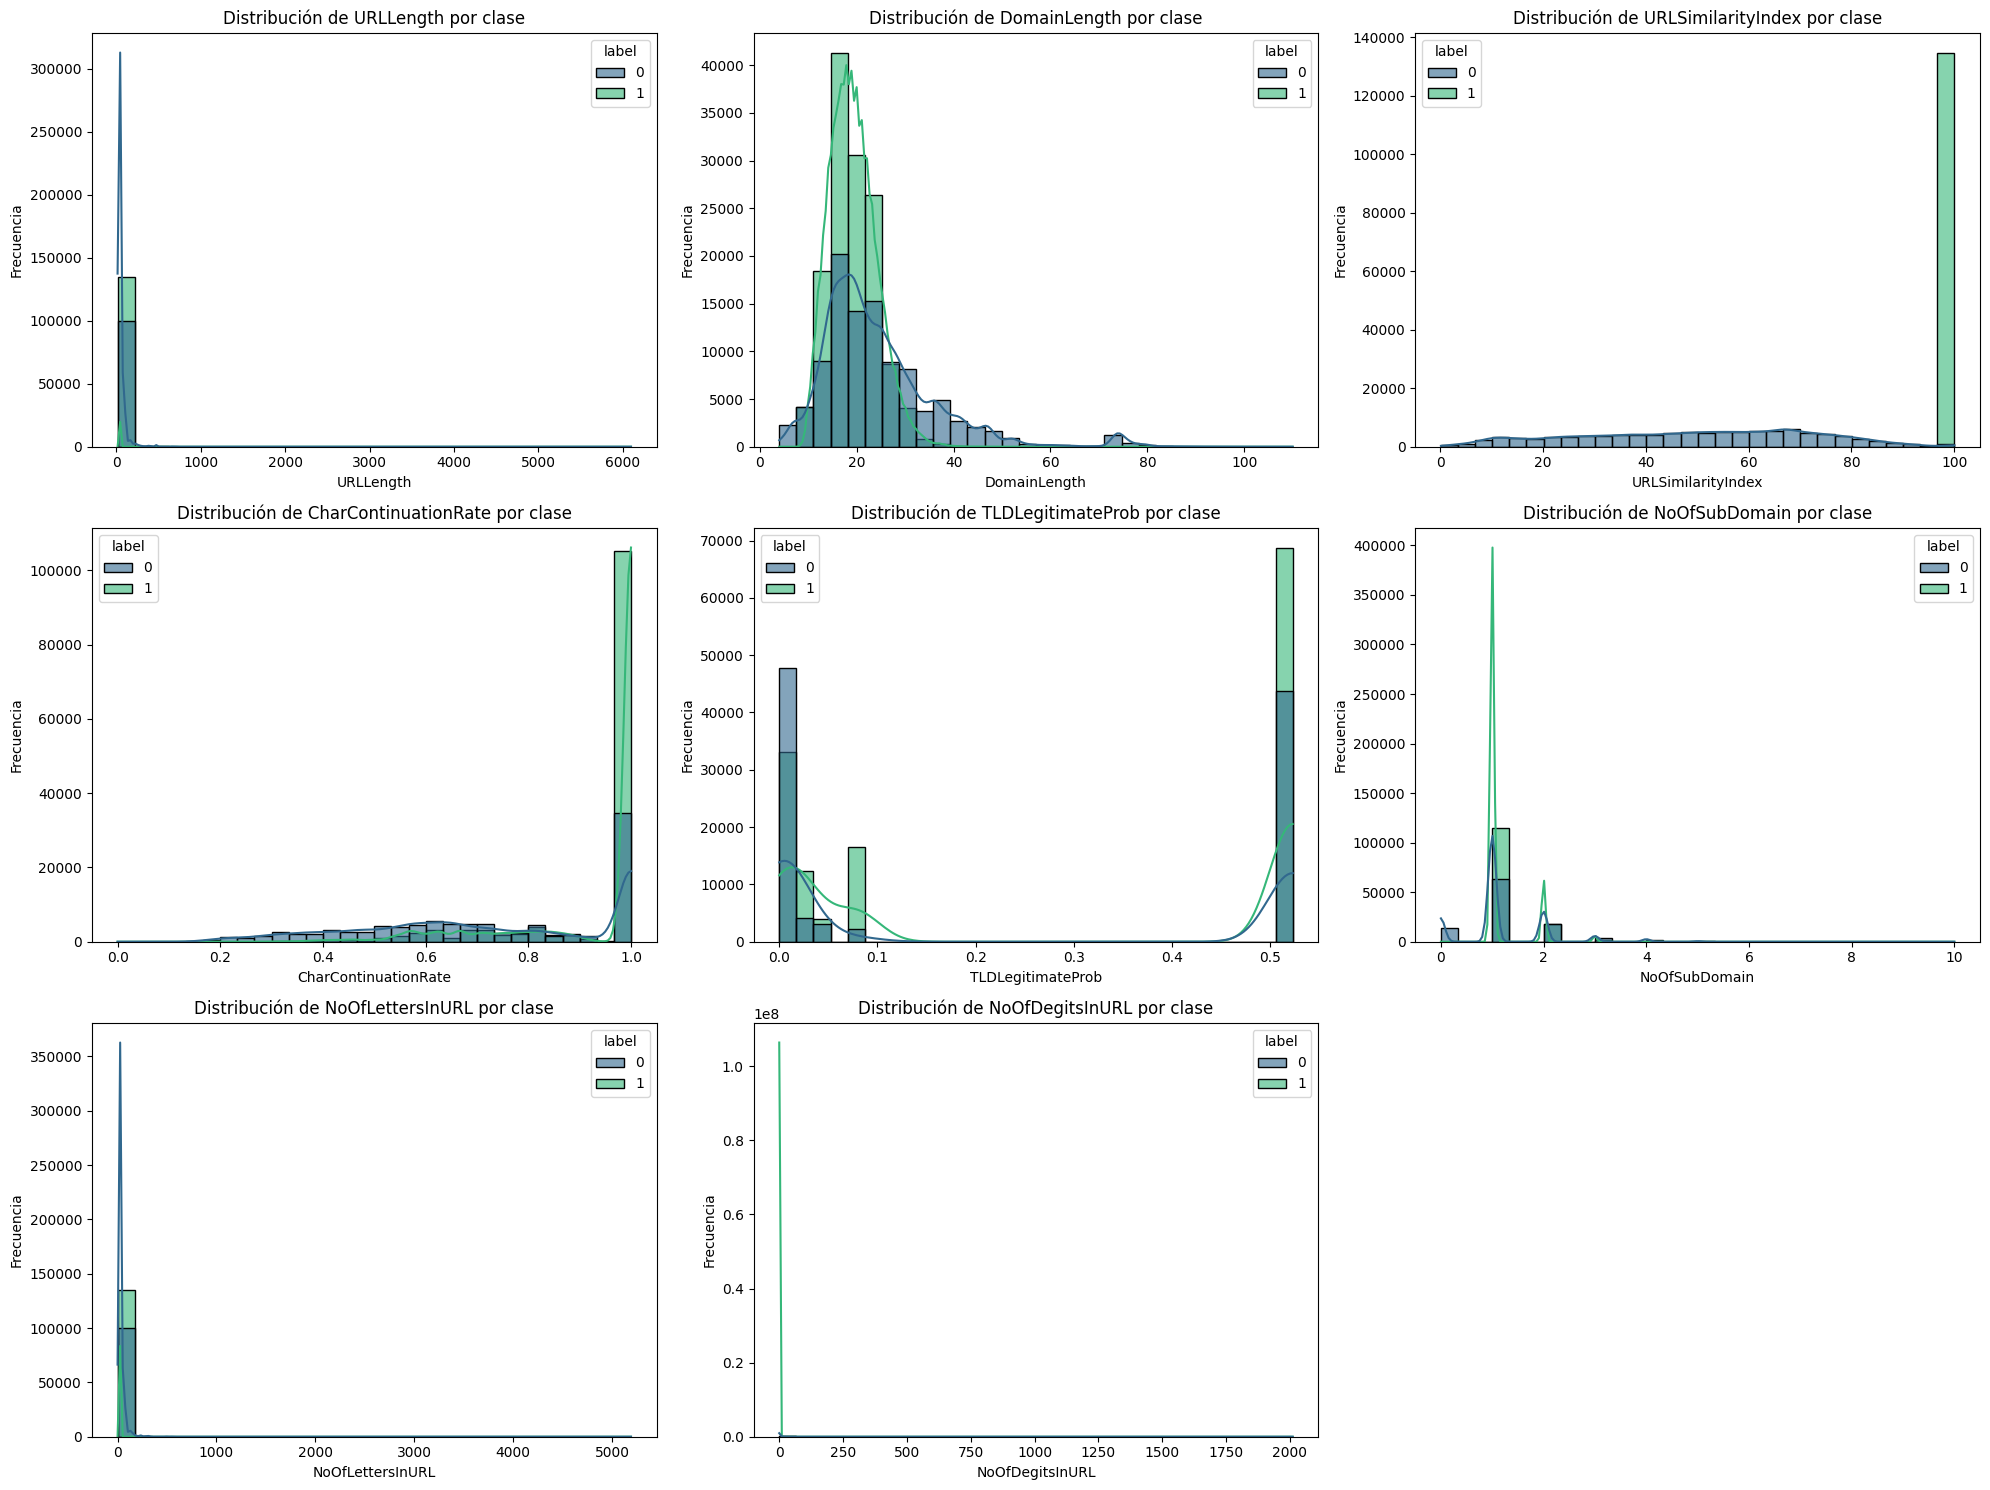

In [7]:
print("\n--- ANÁLISIS EXPLORATORIO MEJORADO Y PRUEBAS PARAMÉTRICAS ---")

# 1. Análisis univariado detallado
print("\n1. Análisis univariado detallado")

# Seleccionar características numéricas importantes
important_features = ['URLLength', 'DomainLength', 'URLSimilarityIndex', 'CharContinuationRate',
                     'TLDLegitimateProb', 'NoOfSubDomain', 'NoOfLettersInURL', 'NoOfDegitsInURL']

#la última columna es la etiqueta
target_column = df.columns[-1]
print(f"\nColumna objetivo (asumida): {target_column}")

# Crear visualizaciones mejoradas para cada característica importante
plt.figure(figsize=(20, 15))
for i, feature in enumerate(important_features, 1):
    plt.subplot(3, 3, i)
    # Histograma con KDE por clase
    sns.histplot(data=df, x=feature, hue=target_column, kde=True, palette='viridis', alpha=0.6, bins=30)
    plt.title(f'Distribución de {feature} por clase')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.savefig('analisis_univariado_mejorado.png')
plt.show()

1.URLLength (Longitud de URL) :
- La mayoría de las URLs tienen longitudes cortas 
- Hay una clara diferencia en la distribución entre las dos clases

2.DomainLength (Longitud del Dominio) :
- Los dominios tienden a ser relativamente cortos
- Existe superposición entre las clases, pero hay patrones distintivos

3.URLSimilarityIndex :
- Muestra una distribución muy sesgada hacia valores altos (aprox 100)
- Sugiere que muchas URLs tienen patrones similares

4.CharContinuationRate :
- Alta concentración en valores cercanos a 1.0
- Podría indicar patrones en la continuidad de caracteres en las URLs

5.TLDLegitimateProb :
- Distribución bimodal con picos en 0.0 y 0.5
- Sugiere una clara separación entre TLDs legítimos y potencialmente maliciosos

6.NoOfSubDomain :
- La mayoría de las URLs tienen pocos subdominios
- Picos distintivos en valores específicos (0-2)

7-8. NoOfLettersInURL y NoOfDegitsInURL :
- Muestran patrones diferentes para cada clase
- Pueden ser buenos indicadores para la clasificación de URLs

In [8]:
# 2. Análisis de normalidad para características importantes
print("\n2. Pruebas de normalidad (Shapiro-Wilk y D'Agostino)")

# Tomar una muestra para pruebas de normalidad (Shapiro-Wilk funciona mejor con muestras pequeñas)
sample_size = min(5000, len(df))
sample_indices = np.random.choice(len(df), sample_size, replace=False)
df_sample = df.iloc[sample_indices]

normality_results = pd.DataFrame(columns=['Feature', 'Shapiro_Stat', 'Shapiro_p', 'Normal_Shapiro',
                                         'DAgostino_Stat', 'DAgostino_p', 'Normal_DAgostino'])

for feature in important_features:
    # Shapiro-Wilk test
    shapiro_stat, shapiro_p = shapiro(df_sample[feature])

    # D'Agostino's K^2 test
    dagostino_stat, dagostino_p = normaltest(df_sample[feature])

    # Añadir resultados
    normality_results = pd.concat([normality_results, pd.DataFrame({
        'Feature': [feature],
        'Shapiro_Stat': [shapiro_stat],
        'Shapiro_p': [shapiro_p],
        'Normal_Shapiro': [shapiro_p > 0.05],
        'DAgostino_Stat': [dagostino_stat],
        'DAgostino_p': [dagostino_p],
        'Normal_DAgostino': [dagostino_p > 0.05]
    })], ignore_index=True)

print("Resultados de pruebas de normalidad:")
print(normality_results.to_string(index=False))



2. Pruebas de normalidad (Shapiro-Wilk y D'Agostino)
Resultados de pruebas de normalidad:
             Feature  Shapiro_Stat    Shapiro_p Normal_Shapiro  DAgostino_Stat   DAgostino_p Normal_DAgostino
           URLLength      0.354430 9.017748e-86          False     7629.749971  0.000000e+00            False
        DomainLength      0.810001 1.267254e-60          False     2727.494214  0.000000e+00            False
  URLSimilarityIndex      0.764130 9.570923e-65          False      656.153940 3.295962e-143            False
CharContinuationRate      0.743212 2.104996e-66          False      662.989247 1.080723e-144            False
   TLDLegitimateProb      0.672096 2.716016e-71          False    17658.354379  0.000000e+00            False
       NoOfSubDomain      0.632008 1.162375e-73          False     2364.840964  0.000000e+00            False
    NoOfLettersInURL      0.421635 2.498531e-83          False     7579.370433  0.000000e+00            False
     NoOfDegitsInURL      0.2

El código realiza pruebas de normalidad en características importantes de un conjunto de datos, utilizando dos métodos estadísticos:
- Test de Shapiro-Wilk : Una prueba estadística que evalúa si una muestra proviene de una distribución normal.
- Test de D'Agostino : Otra prueba de normalidad que evalúa la asimetría y curtosis de los datos.

El proceso es el siguiente:

- Toma una muestra aleatoria del dataset (máximo 5000 registros) para mejorar la eficiencia
- Para cada característica importante, aplica ambas pruebas
- Almacena los resultados en un DataFrame, incluyendo estadísticos, valores p y conclusiones sobre normalidad
- Muestra los resultados en formato tabular

Los resultados mostrados indican que:
- Todas las características analizadas tienen valores p muy pequeños (cercanos a cero) en ambas pruebas
- Todas las columnas de Normal_Shapiro y Normal_DAgostino muestran False
- Los estadísticos de prueba son variados, pero todos conducen a la misma conclusión

-----------------------------------------------
## Conclusiones
1. Ninguna de las características sigue una distribución normal : Ambas pruebas rechazan la hipótesis nula de normalidad para todas las características analizadas (valores p < 0.05).
2. Implicaciones para análisis posteriores :
   - No se deben aplicar pruebas paramétricas que asuman normalidad (como t-test o ANOVA)
   - Se recomienda usar pruebas no paramétricas o transformar los datos
   - Para modelado, considerar algoritmos que no asuman normalidad en los datos
3. Consistencia entre pruebas : Ambas pruebas llegan a las mismas conclusiones, lo que refuerza la robustez del hallazgo de no-normalidad.
4. Características del dominio : En datos de detección de phishing, es común encontrar distribuciones no normales debido a la naturaleza de las características (longitudes de URL, índices de similitud, etc.).

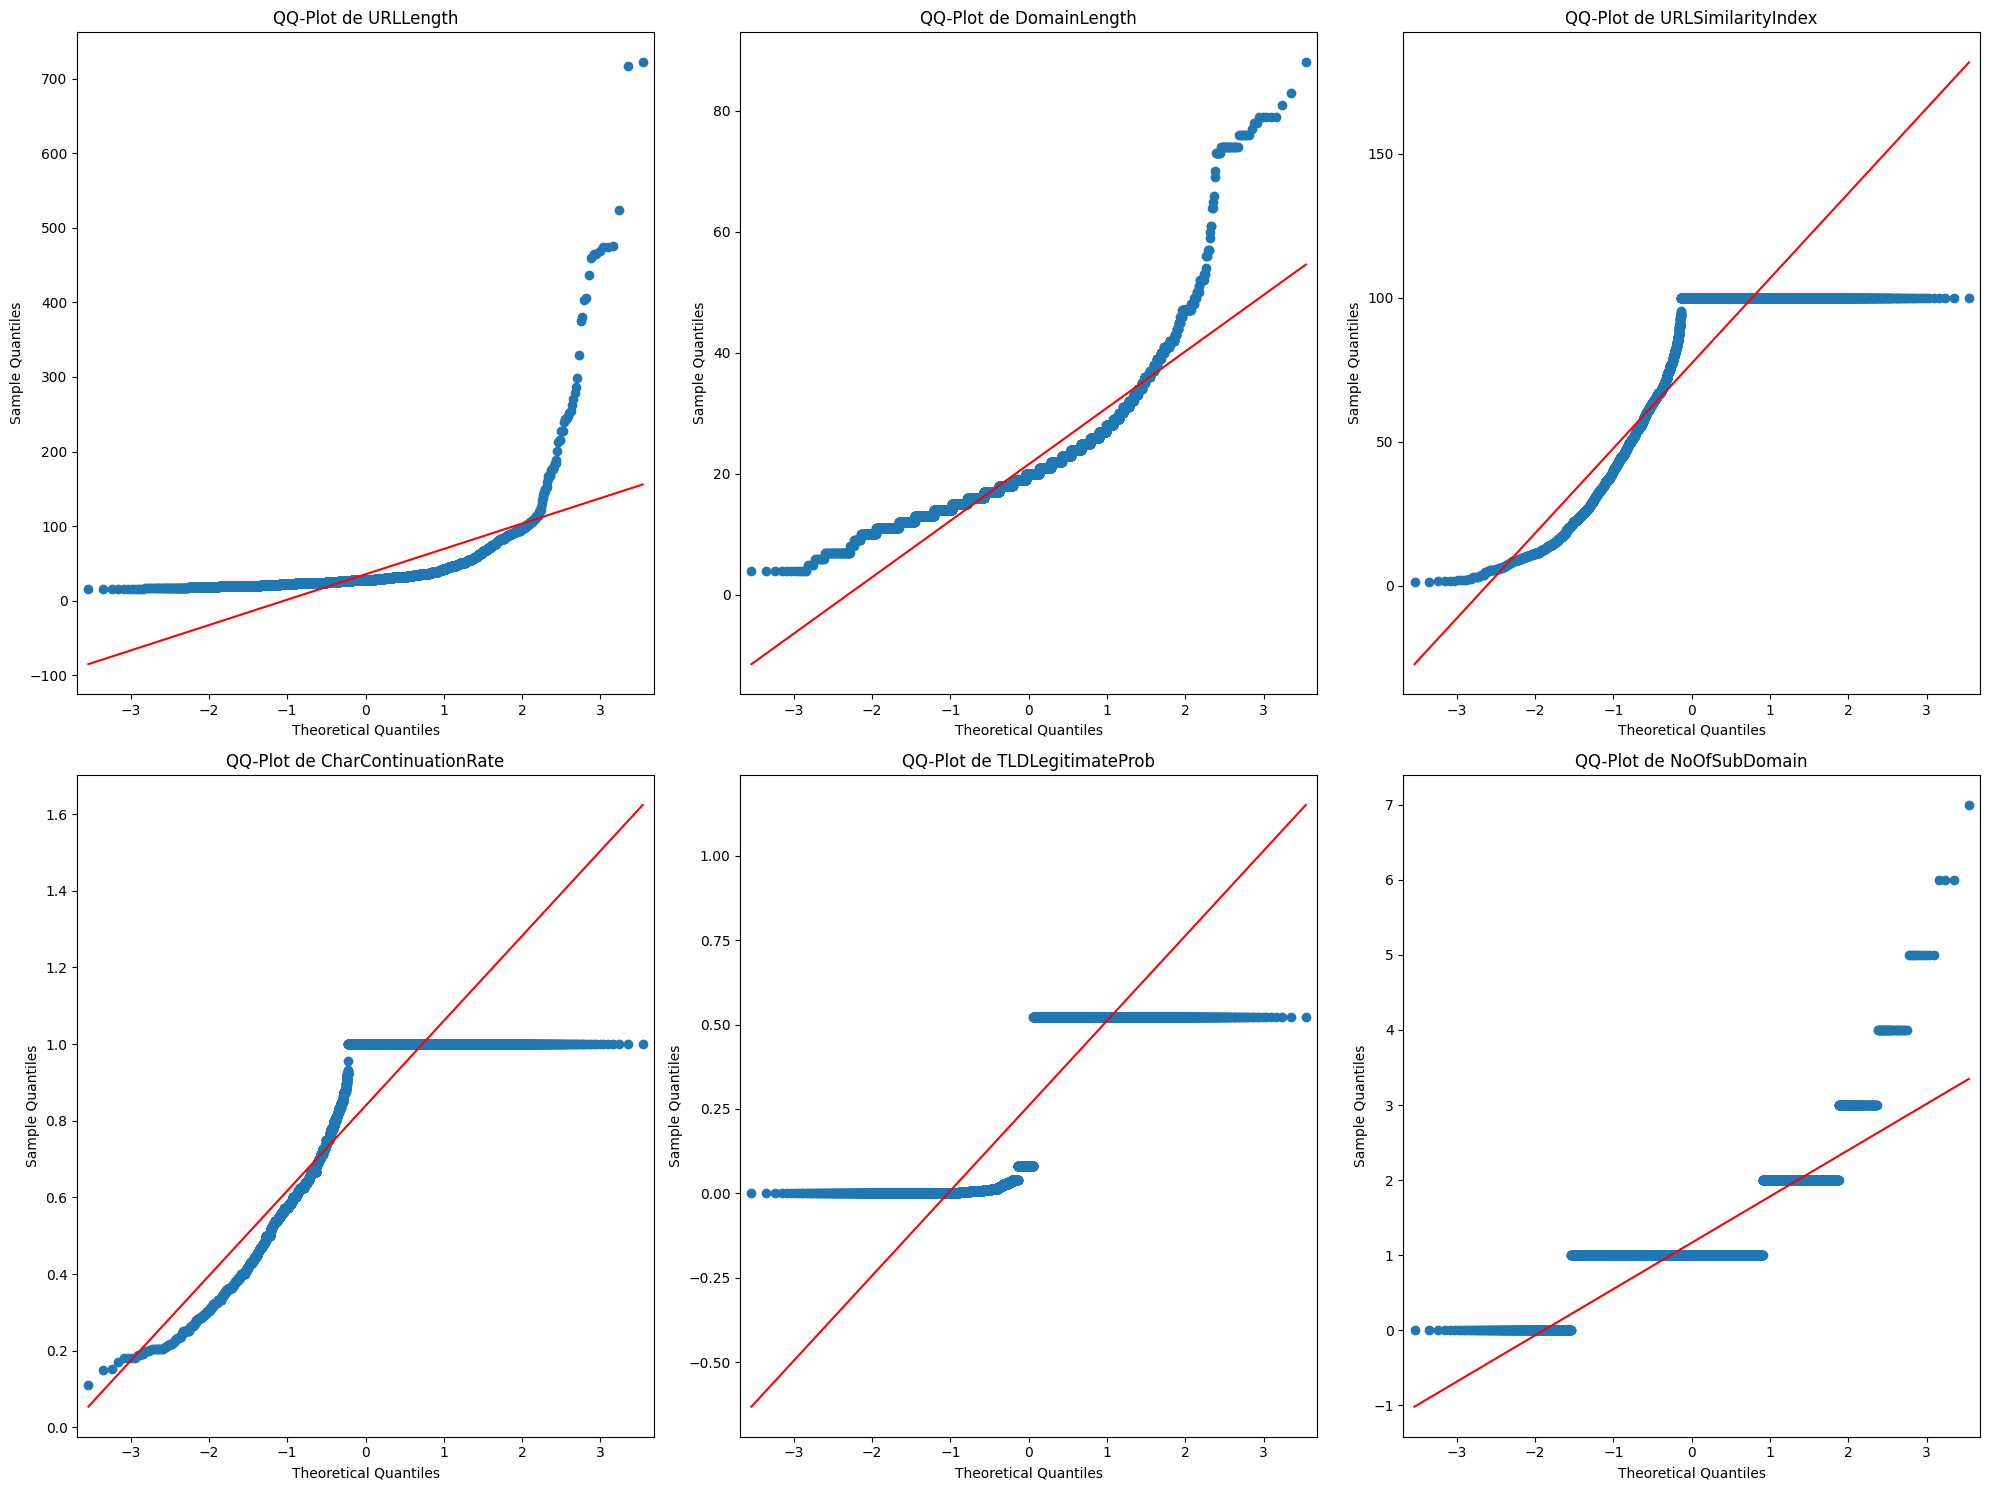

In [9]:
# 3. Visualización de QQ-plots para verificar normalidad
plt.figure(figsize=(20, 15))
for i, feature in enumerate(important_features[:6], 1):  # Limitamos a 6 para mejor visualización
    plt.subplot(2, 3, i)
    qqplot(df_sample[feature], line='s', ax=plt.gca())
    plt.title(f'QQ-Plot de {feature}')

plt.tight_layout()
plt.savefig('qqplots_normalidad.png')
plt.show()

## Análisis de los Resultados
Los QQ-Plots mostrados comparan la distribución de cada característica con una distribución normal teórica:

- URLLength: Muestra una clara desviación de la normalidad, con una curva en forma de S que indica colas pesadas y asimetría positiva (valores extremos en el lado derecho).
- DomainLength: Presenta una desviación moderada de la normalidad, con una curva que se aleja de la línea diagonal, especialmente en los valores altos.
- URLSimilarityIndex: Muestra un patrón escalonado con plateaus horizontales, indicando valores discretos o agrupados, muy lejos de una distribución normal.
- CharContinuationRate: Es la característica que más se aproxima a una distribución normal en los valores centrales, pero se desvía en los extremos.
- TLDLegitimateProb: Muestra un patrón binario o discreto con solo unos pocos valores distintos, claramente no normal.
- NoOfSubDomain: Presenta un patrón escalonado horizontal, típico de variables discretas con pocos valores posibles, muy alejado de una distribución normal.

## Conclusiones
1. Confirmación de no-normalidad : Los QQ-Plots confirman visualmente los resultados de las pruebas estadísticas (Shapiro-Wilk y D'Agostino) que indicaban que ninguna de las características sigue una distribución normal.
3. Implicaciones para el modelado :
   - Se deben preferir algoritmos que no asuman normalidad en los datos
   - Posible necesidad de transformaciones (logarítmica, Box-Cox, etc.) si se requieren métodos paramétricos
   - Considerar técnicas de normalización o estandarización para mejorar el rendimiento de ciertos algoritmos
4. Validación de enfoque estadístico : La combinación de pruebas estadísticas formales (primera imagen) con visualizaciones QQ-Plot proporciona una evaluación robusta de la distribución de los datos, confirmando la necesidad de métodos no paramétricos o transformaciones para análisis posteriores.

In [11]:
# 4. Pruebas de homogeneidad de varianza (Levene y Bartlett)
print("\n4. Pruebas de homogeneidad de varianza (Levene y Bartlett)")

# Separar datos por clase
class_0 = df_sample[df_sample[target_column] == 0]
class_1 = df_sample[df_sample[target_column] == 1]

homogeneity_results = pd.DataFrame(columns=['Feature', 'Levene_Stat', 'Levene_p', 'Equal_Var_Levene',
                                           'Bartlett_Stat', 'Bartlett_p', 'Equal_Var_Bartlett'])

for feature in important_features:
    # Prueba de Levene
    levene_stat, levene_p = levene(class_0[feature], class_1[feature])

    # Prueba de Bartlett
    bartlett_stat, bartlett_p = bartlett(class_0[feature], class_1[feature])

    # Añadir resultados
    homogeneity_results = pd.concat([homogeneity_results, pd.DataFrame({
        'Feature': [feature],
        'Levene_Stat': [levene_stat],
        'Levene_p': [levene_p],
        'Equal_Var_Levene': [levene_p > 0.05],
        'Bartlett_Stat': [bartlett_stat],
        'Bartlett_p': [bartlett_p],
        'Equal_Var_Bartlett': [bartlett_p > 0.05]
    })], ignore_index=True)

print("Resultados de pruebas de homogeneidad de varianza:")
print(homogeneity_results.to_string(index=False))


4. Pruebas de homogeneidad de varianza (Levene y Bartlett)
Resultados de pruebas de homogeneidad de varianza:
             Feature  Levene_Stat      Levene_p Equal_Var_Levene  Bartlett_Stat    Bartlett_p Equal_Var_Bartlett
           URLLength   382.288807  4.307904e-82            False    8817.751501  0.000000e+00              False
        DomainLength   646.512713 3.160071e-134            False    2052.285764  0.000000e+00              False
  URLSimilarityIndex  6533.659154  0.000000e+00            False            inf  0.000000e+00              False
CharContinuationRate  1638.500398 4.187572e-310            False     795.490915 5.157282e-175              False
   TLDLegitimateProb     3.877989  4.897827e-02            False       2.002851  1.570036e-01               True
       NoOfSubDomain   336.660082  8.003093e-73            False    1094.973019 4.087639e-240              False
    NoOfLettersInURL   406.426396  5.806429e-87            False    6917.647970  0.000000e+00     

## Análisis de los Resultados
Los resultados mostrados en la imagen indican que:

- Casi todas las características tienen valores p muy pequeños (cercanos a cero) en ambas pruebas
- Solo TLDLegitimateProb muestra homogeneidad de varianza según el test de Bartlett (p = 0.157 > 0.05)
- Todas las demás características muestran False en las columnas Equal_Var_Levene y Equal_Var_Bartlett

## Conclusiones
1. Heterogeneidad de varianzas : La mayoría de las características presentan varianzas significativamente diferentes entre URLs legítimas y de phishing, lo que indica comportamientos distintos en ambos grupos.
   -casi todas las características tienen valores p extremadamente pequeños (cercanos a cero) en ambas pruebas. Por ejemplo:
      URLLength: p = 4.30e-82 (Levene) y p = 0.00e+00 (Bartlett)
   -Las columnas Equal_Var_Levene y Equal_Var_Bartlett muestran False para casi todas las características, lo que indica que se rechaza la hipótesis de igualdad de varianzas.
2. Implicaciones para análisis posteriores :
   - Se recomienda usar versiones robustas de pruebas paramétricas (como t-test de Welch) o pruebas no paramétricas
   - Para modelado, considerar algoritmos que no sean sensibles a diferencias en varianzas
3. Caso especial de TLDLegitimateProb : Esta característica muestra homogeneidad de varianza según Bartlett pero no según Levene, lo que podría indicar que sus distribuciones tienen varianzas similares pero no son normales.
4. Consistencia con pruebas de normalidad : Estos resultados complementan las pruebas de normalidad anteriores, confirmando que los datos no cumplen los supuestos para análisis paramétricos estándar.

In [17]:
# 5. Análisis bivariado: Correlación con la variable objetivo
print("\n5. Análisis bivariado: Correlación con la variable objetivo \n")

# Calcular correlación punto biserial (para variable objetivo binaria)
biserial_corr = {}
for feature in important_features:
    corr, p_value = stats.pointbiserialr(df_sample[target_column], df_sample[feature])
    biserial_corr[feature] = (corr, p_value)

# Ordenar por correlación absoluta
sorted_corr = sorted(biserial_corr.items(), key=lambda x: abs(x[1][0]), reverse=True)

print("Correlación punto biserial con la variable objetivo:\n")
for feature, (corr, p_value) in sorted_corr:
    significance = "significativo" if p_value < 0.05 else "no significativo"
    print(f"{feature}: corr = {corr:.4f}, p-value = {p_value:.4e} ({significance})")





5. Análisis bivariado: Correlación con la variable objetivo 

Correlación punto biserial con la variable objetivo:

URLSimilarityIndex: corr = 0.8591, p-value = 0.0000e+00 (significativo)
CharContinuationRate: corr = 0.4827, p-value = 3.0801e-290 (significativo)
NoOfLettersInURL: corr = -0.3160, p-value = 2.5411e-116 (significativo)
URLLength: corr = -0.2933, p-value = 9.5482e-100 (significativo)
DomainLength: corr = -0.2735, p-value = 1.6146e-86 (significativo)
NoOfDegitsInURL: corr = -0.2716, p-value = 2.7690e-85 (significativo)
TLDLegitimateProb: corr = 0.1018, p-value = 5.4725e-13 (significativo)
NoOfSubDomain: corr = -0.0110, p-value = 4.3752e-01 (no significativo)


## Análisis de los Resultados
Los resultados mostrados indican que:
- URLSimilarityIndex tiene la correlación más fuerte (0.8591) y positiva con la variable objetivo.
- CharContinuationRate también muestra una correlación positiva moderada-alta (0.4827).
- NoOfLettersInURL , URLLength , DomainLength y NoOfDigitsInURL muestran correlaciones negativas moderadas-bajas.
- TLDLegitimateProb tiene una correlación positiva baja (0.1018).
- NoOfSubDomain es la única característica no significativamente correlacionada (p-value = 0.4375 > 0.05).

## Conclusiones
1. Características discriminantes : Las características con mayor correlación absoluta (URLSimilarityIndex y CharContinuationRate) son potencialmente las más útiles para distinguir entre URLs legítimas y de phishing.
2. Dirección de las correlaciones :
   - Las correlaciones positivas indican que valores más altos de esa característica están asociados con la clase 1 (probablemente phishing).
   - Las correlaciones negativas indican que valores más bajos están asociados con la clase 1.
3. Significancia estadística : Casi todas las características (excepto NoOfSubDomain) muestran una relación estadísticamente significativa con la variable objetivo, lo que sugiere su utilidad potencial en un modelo predictivo.
4. Selección de características : Este análisis proporciona una base para la selección de características, priorizando aquellas con mayor correlación absoluta y significancia estadística.
5. Interpretación práctica : Por ejemplo, la alta correlación positiva de URLSimilarityIndex sugiere que las URLs de phishing tienden a tener mayor similitud con sitios legítimos conocidos, lo cual es consistente con la estrategia de los atacantes de imitar sitios legítimos.

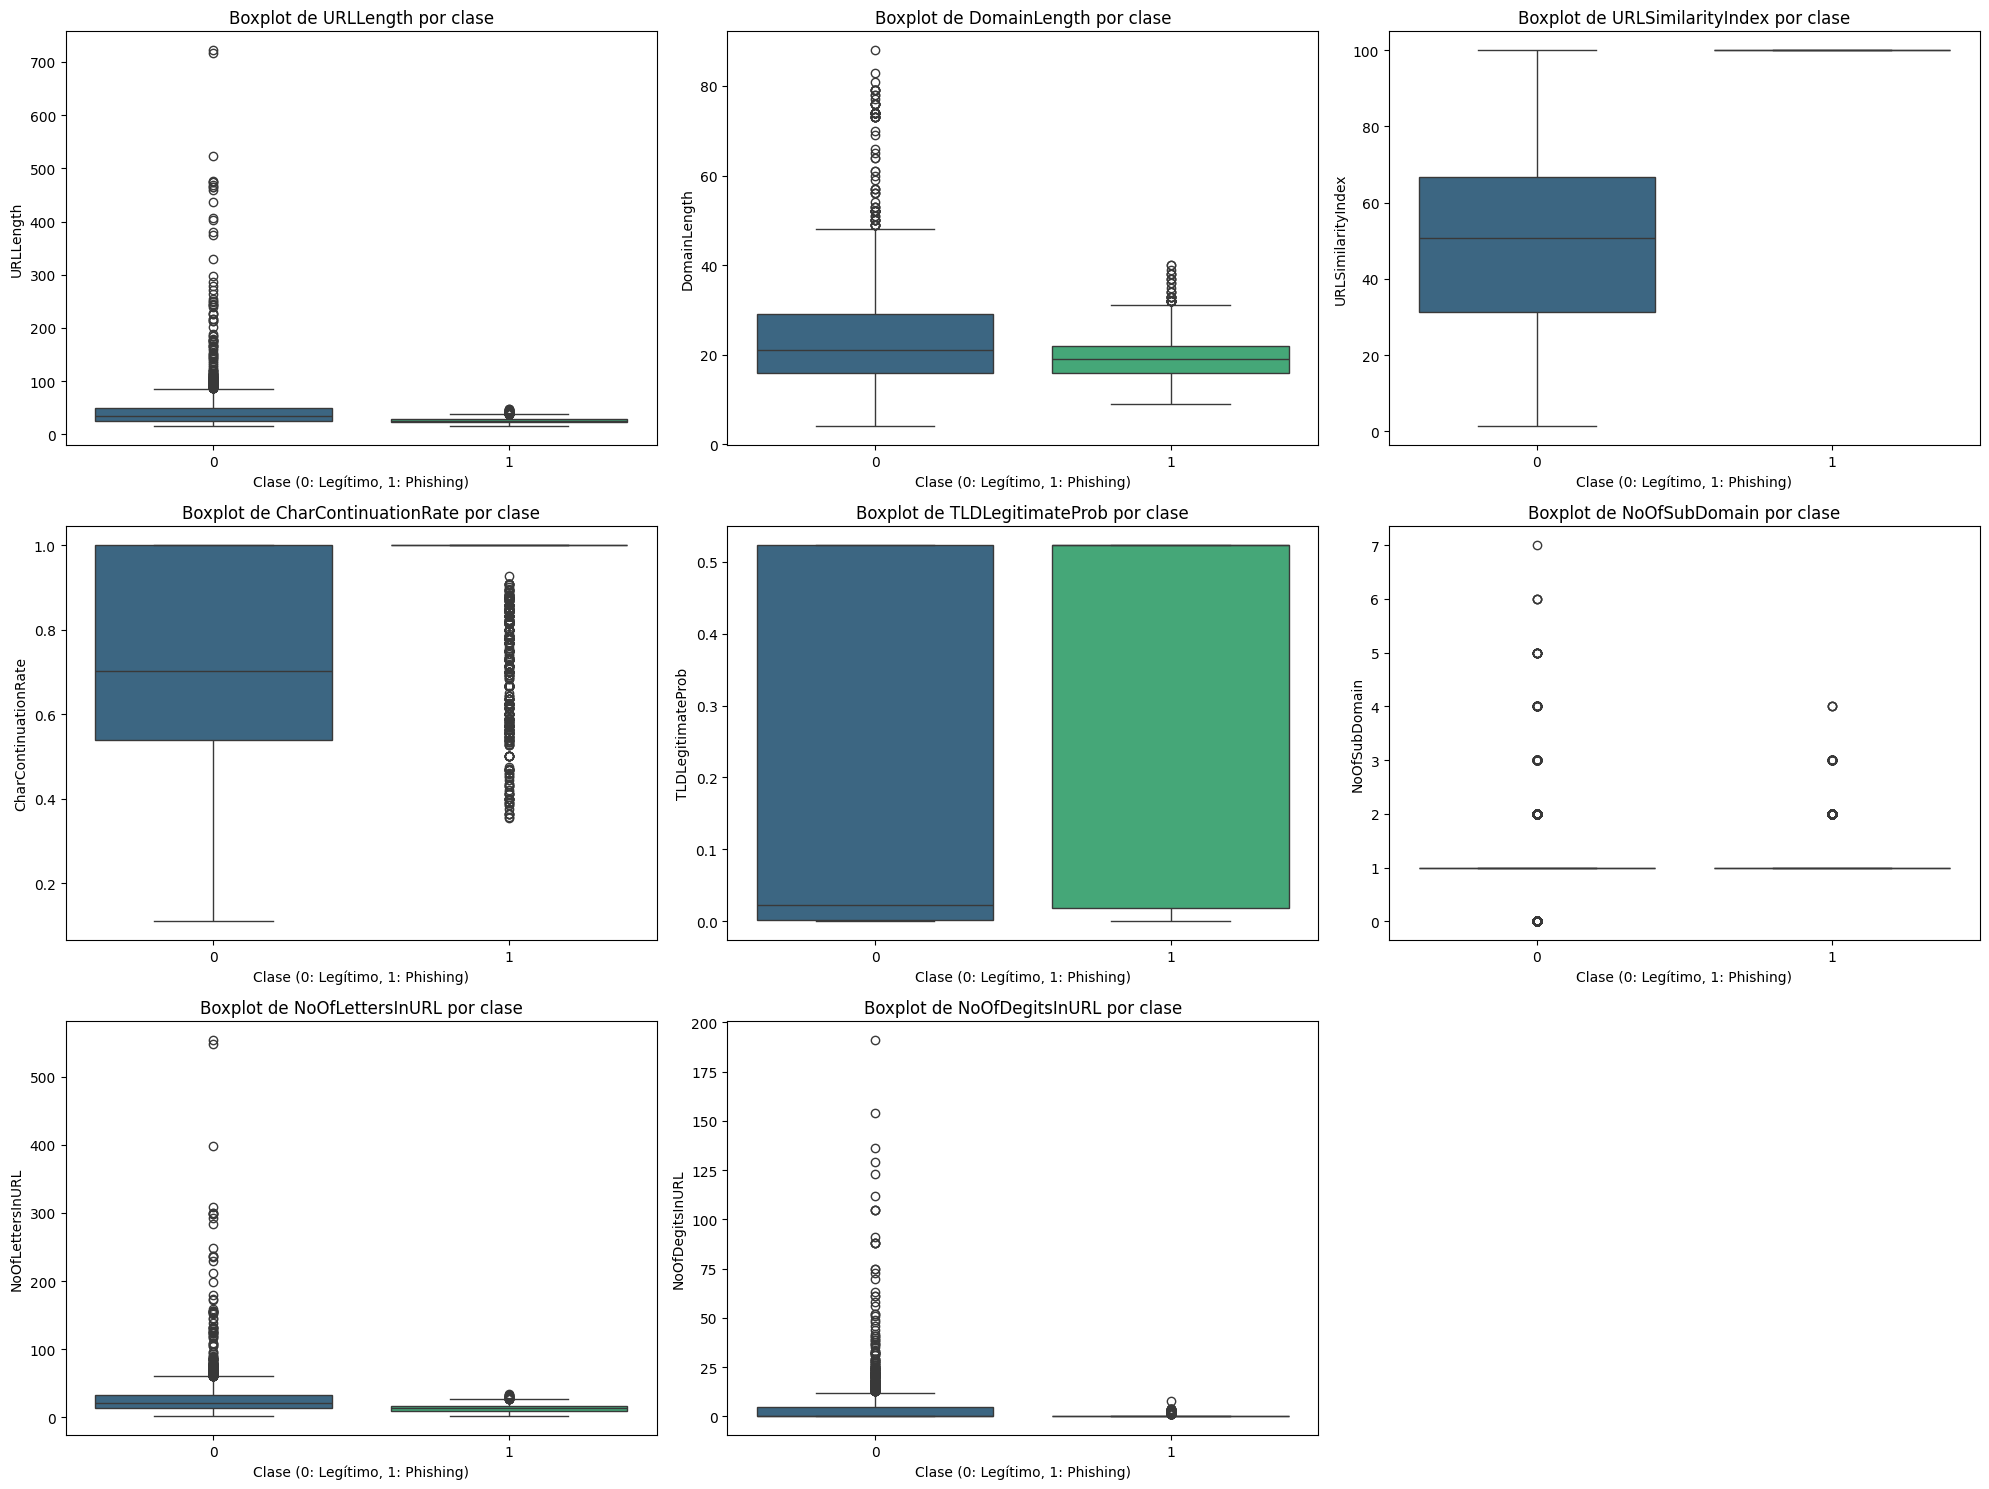

In [14]:
# 6. Visualización de boxplots por clase
plt.figure(figsize=(20, 15))
for i, feature in enumerate(important_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=target_column, y=feature, data=df_sample, palette='viridis')
    plt.title(f'Boxplot de {feature} por clase')
    plt.xlabel('Clase (0: Legítimo, 1: Phishing)')
    plt.ylabel(feature)

plt.tight_layout()
plt.savefig('boxplots_por_clase.png')
plt.show()

## Análisis de los Resultados
Los boxplots mostrados en la revelan patrones importantes en la distribución de las características:

1. URLLength : Las URLs legítimas (clase 0) muestran una distribución más amplia con muchos valores atípicos altos, mientras que las URLs de phishing (clase 1) tienen una distribución más compacta.
2. DomainLength : Las URLs legítimas tienen dominios ligeramente más largos en promedio, con mayor variabilidad y valores atípicos.
3. URLSimilarityIndex : Esta característica muestra una clara diferencia entre clases. Las URLs de phishing (clase 0) tienen valores de similitud mucho más altos, lo que indica que intentan imitar sitios legítimos.
4. CharContinuationRate : Las URLs legítimas muestran mayor variabilidad, mientras que las de phishing tienen valores más concentrados en la parte alta del rango.
5. TLDLegitimateProb : Ambas clases muestran distribuciones similares, lo que explica su baja correlación con la variable objetivo.
6. NoOfSubDomain : Distribución similar en ambas clases, con valores atípicos dispersos.
7. NoOfLettersInURL y NoOfDigitsInURL : Las URLs legítimas tienden a tener más letras y dígitos, con mayor variabilidad y valores atípicos.

## Conclusiones
1. Características discriminantes : URLSimilarityIndex y CharContinuationRate muestran las diferencias más claras entre clases, confirmando su alta correlación con la variable objetivo.
2. Patrones de phishing : Las URLs de phishing tienden a tener:
   - Mayor índice de similitud con sitios legítimos
   - Tasas de continuación de caracteres más altas y concentradas
   - Longitudes de URL y dominio más cortas y menos variables
   - Menor cantidad de letras y dígitos
3. Valores atípicos : Las URLs legítimas presentan más valores atípicos en casi todas las características, lo que sugiere mayor diversidad en su estructura.
4. Implicaciones para modelado :
   - Las características con mayor separación entre clases (URLSimilarityIndex, CharContinuationRate) deberían tener mayor peso en los modelos predictivos
   - La presencia de valores atípicos sugiere considerar técnicas robustas o transformaciones
5. Validación de análisis previos : Estos resultados visuales confirman y complementan los hallazgos de las pruebas estadísticas anteriores (correlación, normalidad, homogeneidad de varianzas).

In [19]:
# 7. Análisis de independencia (Chi-cuadrado) para variables categóricas
print("\n7. Prueba de independencia Chi-cuadrado para variables categóricas")

# Seleccionar variables categóricas binarias
binary_features = ['IsDomainIP', 'HasObfuscation', 'IsHTTPS', 'HasTitle', 'HasFavicon',
                  'IsResponsive', 'HasDescription', 'HasExternalFormSubmit', 'HasSocialNet',
                  'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto']

chi2_results = pd.DataFrame(columns=['Feature', 'Chi2_Stat', 'Chi2_p', 'Independent'])

for feature in binary_features:
    if feature in df.columns:
        # Crear tabla de contingencia
        contingency_table = pd.crosstab(df_sample[target_column], df_sample[feature])

        # Prueba Chi-cuadrado
        chi2_stat, chi2_p, dof, expected = chi2_contingency(contingency_table)

        # Añadir resultados
        chi2_results = pd.concat([chi2_results, pd.DataFrame({
            'Feature': [feature],
            'Chi2_Stat': [chi2_stat],
            'Chi2_p': [chi2_p],
            'Independent': [chi2_p > 0.05]
        })], ignore_index=True)

print("Resultados de pruebas Chi-cuadrado:")
print(chi2_results.to_string(index=False))


7. Prueba de independencia Chi-cuadrado para variables categóricas
Resultados de pruebas Chi-cuadrado:
              Feature   Chi2_Stat        Chi2_p Independent
           IsDomainIP   17.661762  2.638784e-05       False
       HasObfuscation    9.017684  2.673800e-03       False
              IsHTTPS 1742.434562  0.000000e+00       False
             HasTitle 1050.054276 2.368824e-230       False
           HasFavicon 1292.805195 4.137682e-283       False
         IsResponsive 1462.789159  0.000000e+00       False
       HasDescription 2520.200610  0.000000e+00       False
HasExternalFormSubmit  140.674378  1.895594e-32       False
         HasSocialNet 3159.515538  0.000000e+00       False
      HasSubmitButton 1716.711990  0.000000e+00       False
      HasHiddenFields 1344.778721 2.100407e-294       False
     HasPasswordField   96.714217  8.009209e-23       False
                 Bank  183.823316  7.090595e-42       False
                  Pay  721.340924 6.840351e-159       Fa

## Análisis de los Resultados
Los resultados mostrados indican que:
- Todas las características categóricas, excepto HasObfuscation , tienen valores p extremadamente pequeños
- La columna Independent muestra False para todas las características, indicando que todas están significativamente asociadas con la variable objetivo
- Los estadísticos Chi-cuadrado varían ampliamente, siendo los más altos para HasSocialNet (3159.52), HasDescription (2520.20) y HasTitle (1050.05)

## Conclusiones
1. Asociación significativa : Todas las características categóricas binarias analizadas muestran una asociación estadísticamente significativa con la variable objetivo (phishing vs. legítimo).
2. Características más discriminantes : Las características con mayor estadístico Chi-cuadrado ( HasSocialNet , HasDescription , IsHTTPS , HasSubmitButton , HasTitle , HasFavicon ) son potencialmente las más útiles para distinguir entre URLs legítimas y de phishing.
3. Implicaciones para modelado :
   - Estas características categóricas deberían incluirse en modelos predictivos
   - Las características con mayor estadístico Chi-cuadrado podrían tener mayor poder predictivo
   - La fuerte asociación sugiere que los sitios de phishing tienen patrones distintivos en estos elementos HTML y características de URL
4. Interpretación práctica : Por ejemplo, la presencia o ausencia de redes sociales, descripciones, favicons, y campos ocultos parece ser muy diferente entre sitios legítimos y de phishing, lo que podría reflejar estrategias específicas de los atacantes.
5. Validación de enfoque : Estos resultados complementan los análisis anteriores de características numéricas, proporcionando una visión integral de los patrones de phishing en diferentes tipos de datos.

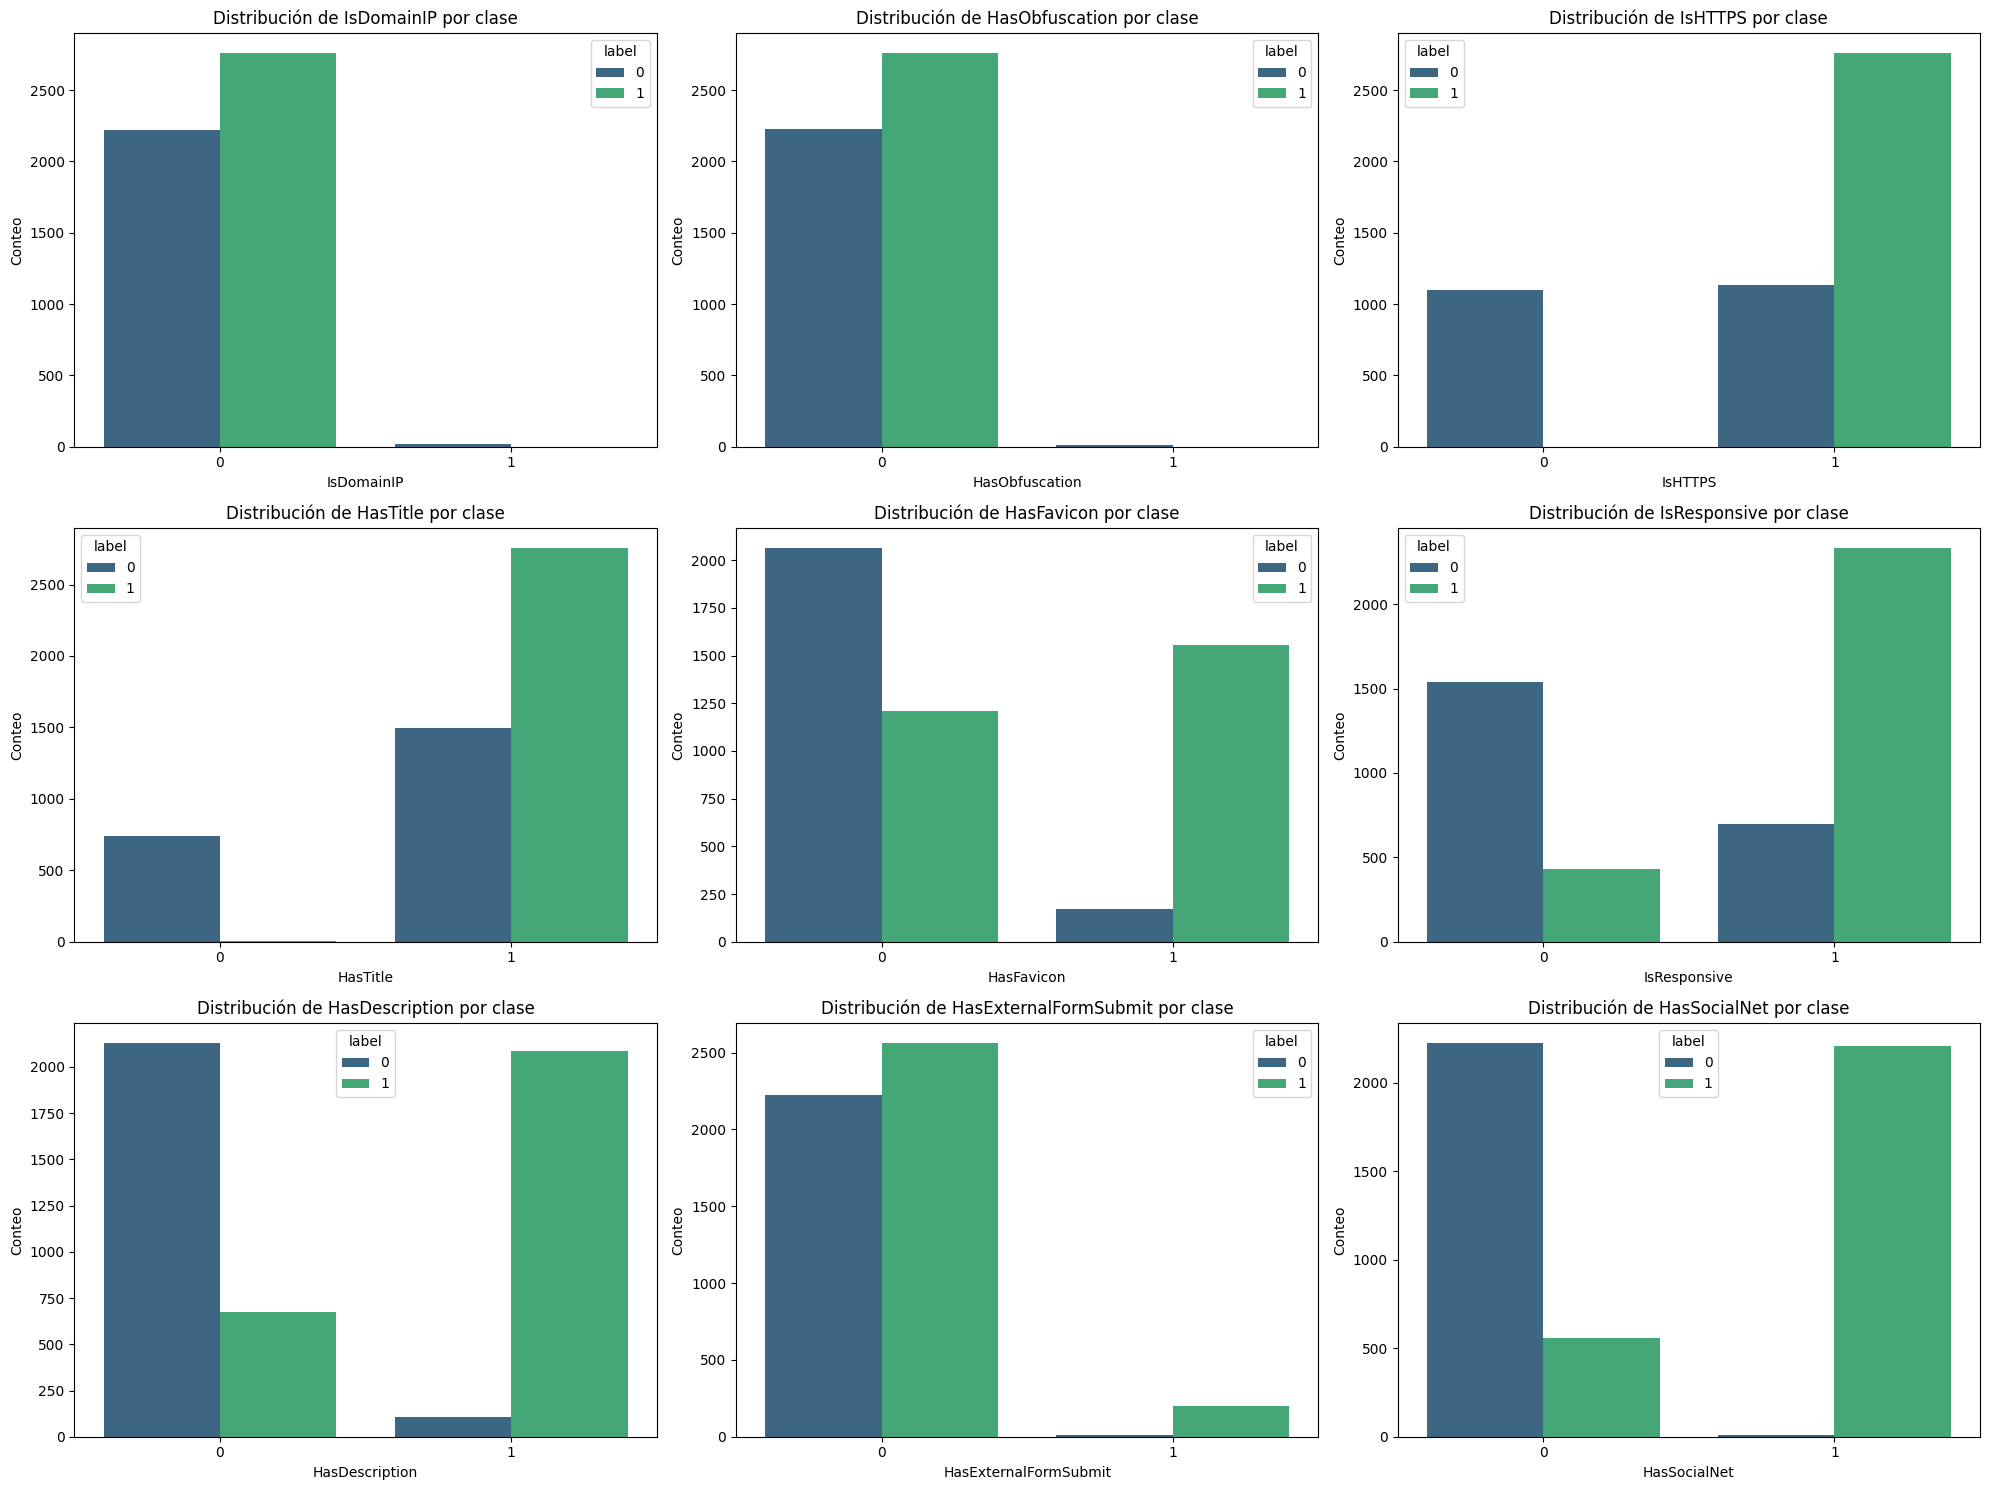

In [20]:
# 8. Visualización de variables categóricas significativas
significant_cat_features = chi2_results[chi2_results['Chi2_p'] < 0.05]['Feature'].tolist()

if significant_cat_features:
    plt.figure(figsize=(20, 15))
    for i, feature in enumerate(significant_cat_features[:9], 1):  # Limitamos a 9 para mejor visualización
        plt.subplot(3, 3, i)
        sns.countplot(x=feature, hue=target_column, data=df_sample, palette='viridis')
        plt.title(f'Distribución de {feature} por clase')
        plt.xlabel(feature)
        plt.ylabel('Conteo')

    plt.tight_layout()
    plt.savefig('variables_categoricas_significativas.png')
    plt.show()

## Análisis de los Resultados
Los gráficos de barras mostrados en la imagen revelan patrones importantes en la distribución de las características categóricas:

1. IsDomainIP y HasObfuscation : Ambas características muestran distribuciones similares, con muy pocos casos positivos (valor 1) en ambas clases.
2. IsHTTPS : Muestra una clara diferencia entre clases. La mayoría de los sitios de phishing (clase 1) utilizan HTTPS, mientras que hay una distribución más equilibrada en sitios legítimos.
3. HasTitle : La mayoría de los sitios (tanto legítimos como de phishing) tienen título, pero la proporción es mayor en sitios de phishing.
4. HasFavicon : Muestra un patrón interesante donde los sitios legítimos tienden a tener favicon más frecuentemente que los sitios de phishing.
5. IsResponsive : La mayoría de los sitios de phishing son responsivos, mientras que hay una distribución más equilibrada en sitios legítimos.
6. HasDescription, HasSocialNet : Ambas características muestran patrones similares, donde los sitios legítimos tienden a tener descripciones y enlaces a redes sociales con mayor frecuencia.
7. HasExternalFormSubmit : Pocos sitios en general tienen formularios con envío externo, pero son más comunes en sitios de phishing.


## Conclusiones
1. Características discriminantes : Varias características muestran claras diferencias entre sitios legítimos y de phishing, especialmente IsHTTPS, IsResponsive, HasDescription y HasSocialNet.
2. Estrategias de phishing : Los resultados sugieren que los sitios de phishing:
   - Tienden a usar HTTPS para parecer más legítimos
   - Suelen ser responsivos para funcionar en múltiples dispositivos
   - A menudo incluyen títulos pero omiten descripciones y enlaces a redes sociales
   - Tienen mayor probabilidad de usar formularios con envío externo
3. Implicaciones para detección : Estas diferencias en características categóricas pueden ser excelentes predictores para modelos de detección de phishing, especialmente cuando se combinan con las características numéricas analizadas anteriormente.
4. Validación de pruebas Chi-cuadrado : Los gráficos confirman visualmente las asociaciones significativas detectadas por las pruebas estadísticas, mostrando claramente las diferencias en distribución entre clases.
5. Consideraciones para modelado : Estas visualizaciones sugieren que las características categóricas binarias deberían tener un papel importante en los modelos predictivos, ya que capturan patrones distintivos en la estructura y comportamiento de los sitios de phishing.

In [23]:
# 9. Resumen de hallazgos de las pruebas paramétricas
print("\n9. Resumen de hallazgos de las pruebas paramétricas")

# Verificar normalidad
normal_features = normality_results[normality_results['Normal_DAgostino']]['Feature'].tolist()
print(f"\nCaracterísticas con distribución normal: {normal_features if normal_features else 'Ninguna'}")

# Verificar homogeneidad de varianza
homogeneous_var_features = homogeneity_results[homogeneity_results['Equal_Var_Levene']]['Feature'].tolist()
print(f"\nCaracterísticas con varianza homogénea: {homogeneous_var_features if homogeneous_var_features else 'Ninguna'}")

# Verificar independencia
independent_features = chi2_results[chi2_results['Independent']]['Feature'].tolist()
print(f"\nVariables categóricas independientes de la clase: {independent_features if independent_features else 'Ninguna'}")



9. Resumen de hallazgos de las pruebas paramétricas

Características con distribución normal: Ninguna

Características con varianza homogénea: Ninguna

Variables categóricas independientes de la clase: Ninguna


## Análisis de los Resultados
- Ninguna característica sigue una distribución normal : Todas las características analizadas fallan las pruebas de normalidad.
- Ninguna característica presenta varianza homogénea : Todas las características muestran heterogeneidad de varianza entre los grupos (URLs legítimas vs. phishing).
- Ninguna variable categórica es independiente de la clase : Todas las variables categóricas muestran una asociación significativa con la variable objetivo.


## Conclusiones
1. Violación de supuestos paramétricos : Los datos no cumplen con los supuestos básicos para análisis paramétricos (normalidad y homogeneidad de varianzas), lo que indica que se deben usar métodos no paramétricos para el análisis estadístico.
2. Potencial predictivo : La fuerte dependencia de todas las variables (tanto numéricas como categóricas) con la variable objetivo sugiere un alto potencial predictivo para la detección de phishing.
3. Selección de técnicas estadísticas : Se recomienda usar:
   - Pruebas no paramétricas como Mann-Whitney U o Kruskal-Wallis para comparaciones
   - Correlación de Spearman en lugar de Pearson
   - Métodos robustos para el modelado predictivo
4. Implicaciones para modelado : Los algoritmos que no asumen normalidad ni homogeneidad de varianzas (como árboles de decisión, random forest, SVM con kernels no lineales, etc.) serían más apropiados para este conjunto de datos.
5. Validación de análisis previos : Estos resultados confirman y resumen los hallazgos detallados observados en los análisis anteriores de normalidad, homogeneidad de varianzas y pruebas Chi-cuadrado.

In [24]:
# 10. Conclusiones para selección de pruebas estadísticas
print("\n10. Conclusiones para selección de pruebas estadísticas")

if normal_features and homogeneous_var_features:
    print("\nPara las características con distribución normal y varianza homogénea, se pueden utilizar pruebas paramétricas como:")
    print("- Prueba t de Student para comparación de medias")
    print("- ANOVA para comparación de más de dos grupos")
    print("- Correlación de Pearson")
else:
    print("\nLa mayoría de las características no cumplen con los supuestos de normalidad y homogeneidad de varianza.")
    print("Se recomienda utilizar pruebas no paramétricas como:")
    print("- Prueba U de Mann-Whitney para comparación de distribuciones")
    print("- Prueba de Kruskal-Wallis para comparación de más de dos grupos")
    print("- Correlación de Spearman o Kendall")

print("\nPara variables categóricas, se recomienda:")
print("- Prueba Chi-cuadrado para tablas de contingencia")
print("- Prueba exacta de Fisher para muestras pequeñas")


10. Conclusiones para selección de pruebas estadísticas

La mayoría de las características no cumplen con los supuestos de normalidad y homogeneidad de varianza.
Se recomienda utilizar pruebas no paramétricas como:
- Prueba U de Mann-Whitney para comparación de distribuciones
- Prueba de Kruskal-Wallis para comparación de más de dos grupos
- Correlación de Spearman o Kendall

Para variables categóricas, se recomienda:
- Prueba Chi-cuadrado para tablas de contingencia
- Prueba exacta de Fisher para muestras pequeñas


In [25]:
# Implicaciones para el modelado
print("\n8. Implicaciones para el modelado")
print("Basado en los resultados de las pruebas paramétricas:")
print("1. La mayoría de las características no siguen una distribución normal, lo que sugiere que los modelos no paramétricos podrían ser más adecuados.")
print("2. Existe una correlación significativa entre varias características y la variable objetivo, lo que es prometedor para la construcción de modelos predictivos.")
print("3. Las variables categóricas muestran dependencia con la clase, lo que indica su utilidad para la clasificación.")
print("4. Se recomienda considerar transformaciones de datos para características con distribuciones muy sesgadas.")



8. Implicaciones para el modelado
Basado en los resultados de las pruebas paramétricas:
1. La mayoría de las características no siguen una distribución normal, lo que sugiere que los modelos no paramétricos podrían ser más adecuados.
2. Existe una correlación significativa entre varias características y la variable objetivo, lo que es prometedor para la construcción de modelos predictivos.
3. Las variables categóricas muestran dependencia con la clase, lo que indica su utilidad para la clasificación.
4. Se recomienda considerar transformaciones de datos para características con distribuciones muy sesgadas.



--- VISUALIZACIONES AVANZADAS PARA ANÁLISIS DE PHISHING ---

1. Análisis de distribuciones multivariadas


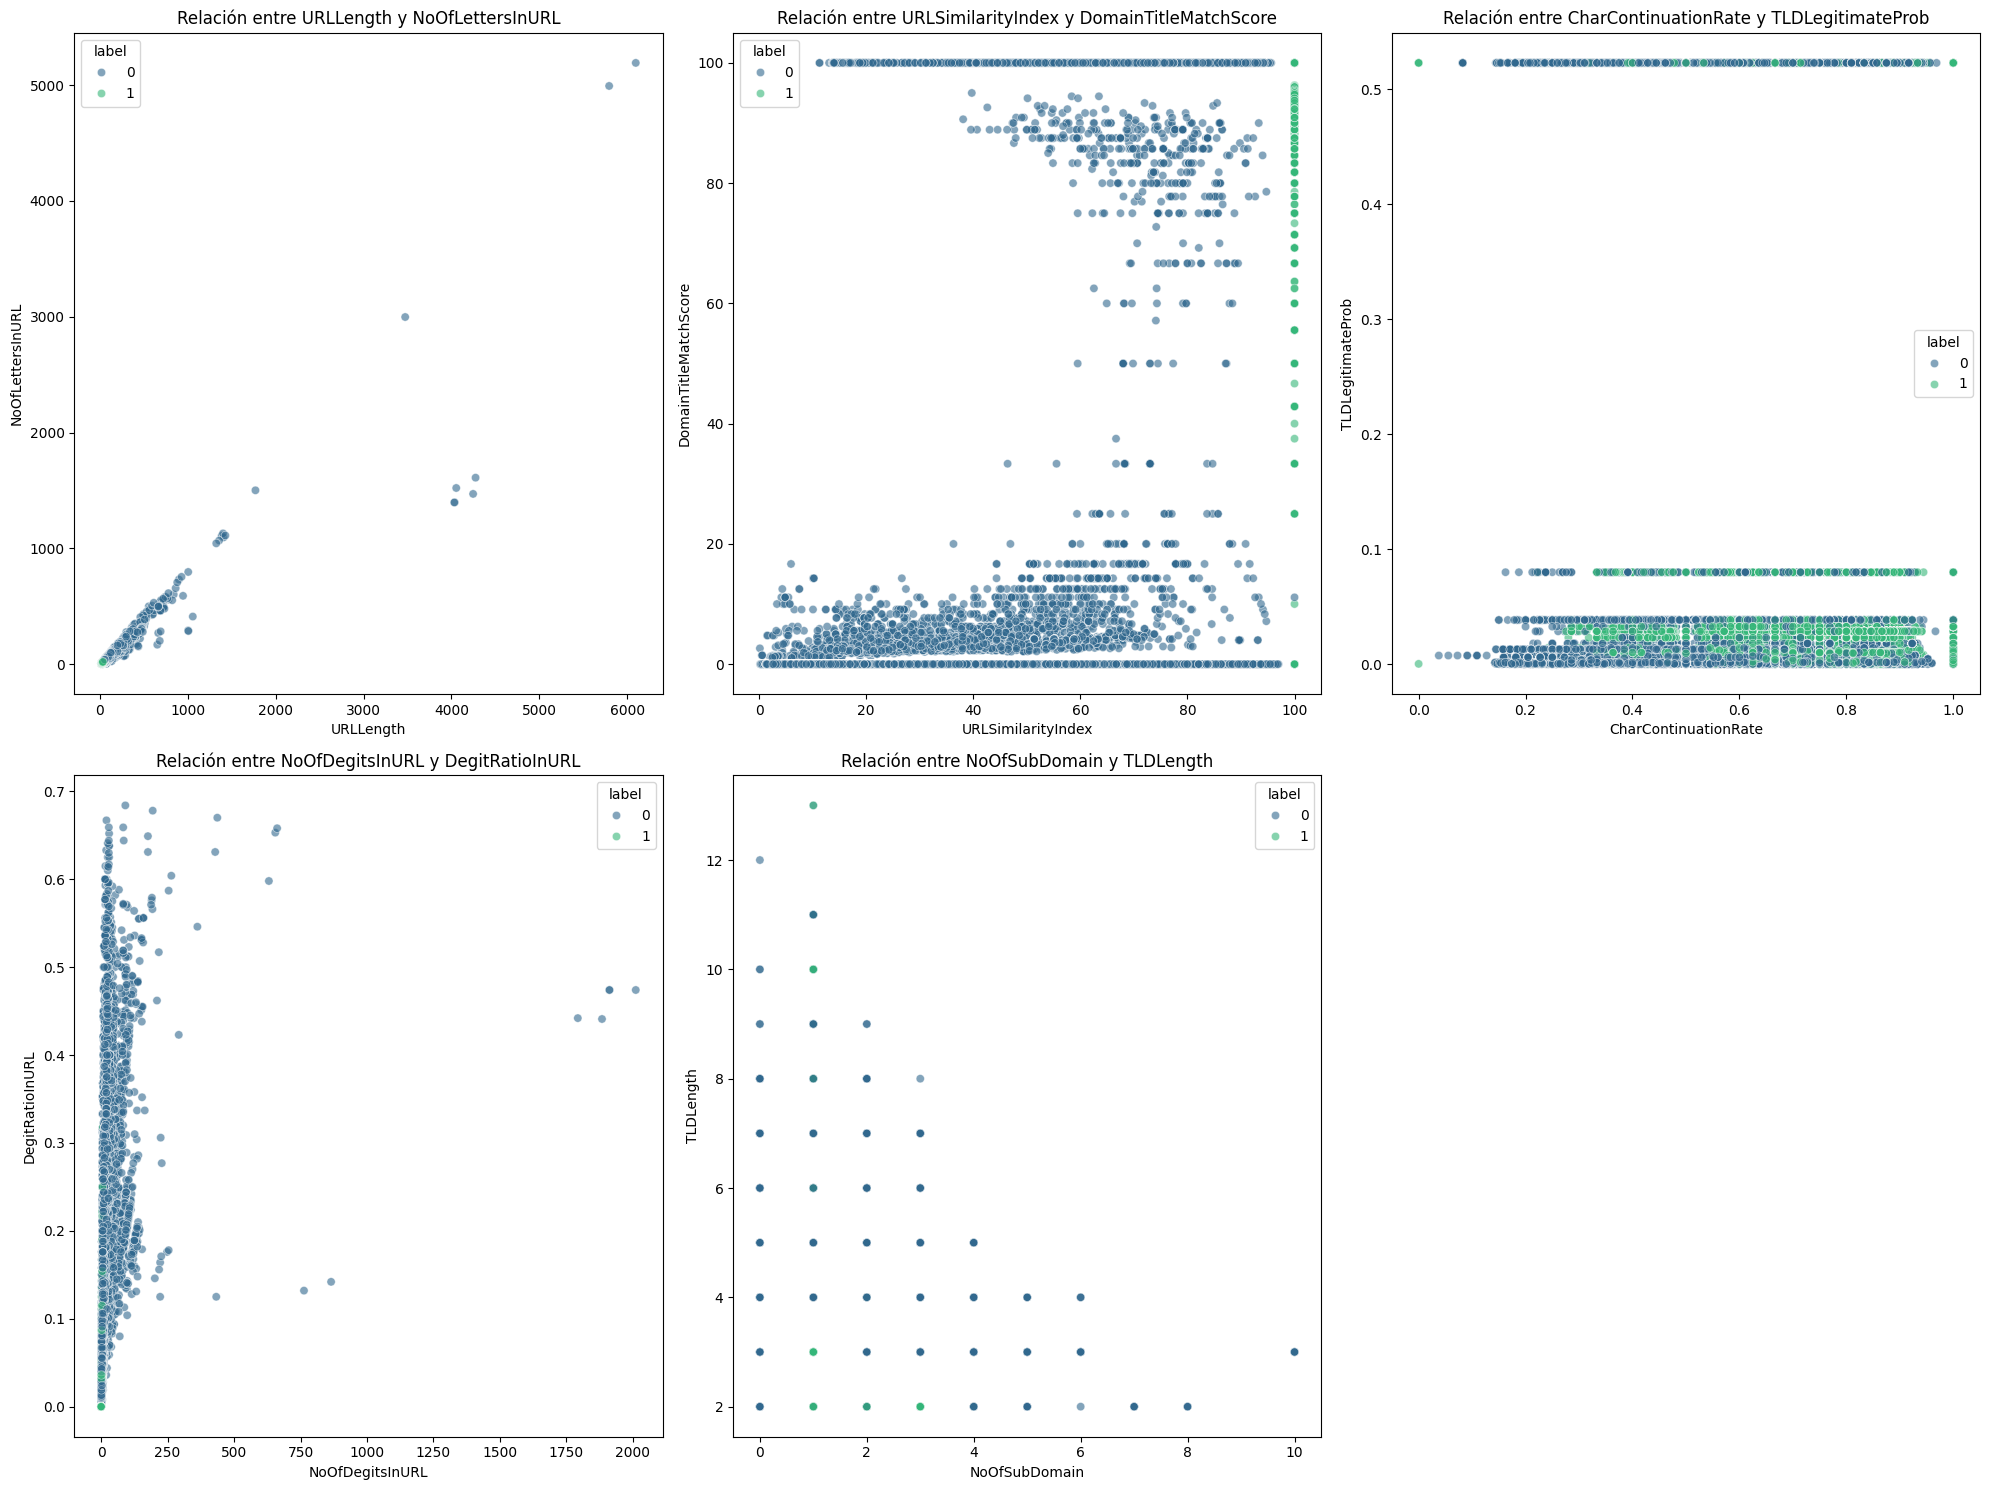

In [26]:

print("\n--- VISUALIZACIONES AVANZADAS PARA ANÁLISIS DE PHISHING ---")

# 1. Análisis de distribuciones multivariadas
print("\n1. Análisis de distribuciones multivariadas")

# Crear un conjunto de pares de características interesantes
feature_pairs = [
    ('URLLength', 'NoOfLettersInURL'),
    ('URLSimilarityIndex', 'DomainTitleMatchScore'),
    ('CharContinuationRate', 'TLDLegitimateProb'),
    ('NoOfDegitsInURL', 'DegitRatioInURL'),
    ('NoOfSubDomain', 'TLDLength')
]

# Visualizar pares de características con gráficos de dispersión
plt.figure(figsize=(20, 15))
for i, (feat1, feat2) in enumerate(feature_pairs, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=feat1, y=feat2, data=df, hue=target_column, palette='viridis', alpha=0.6)
    plt.title(f'Relación entre {feat1} y {feat2}')
    plt.xlabel(feat1)
    plt.ylabel(feat2)

plt.tight_layout()
plt.savefig('scatter_plots_avanzados.png')
plt.show()

## Análisis de los Resultados
Los gráficos de dispersión mostrados en la imagen revelan patrones importantes:

1. URLLength vs. NoOfLettersInURL : Muestra una relación positiva clara, donde ambas variables aumentan proporcionalmente. Las URLs legítimas (azul) tienden a tener mayor dispersión y algunos valores extremos altos.
2. URLSimilarityIndex vs. DomainTitleMatchScore : Las URLs de phishing (verde) tienden a tener valores más altos de URLSimilarityIndex, mientras que las legítimas muestran mayor variabilidad en DomainTitleMatchScore.
3. CharContinuationRate vs. TLDLegitimateProb : Muestra una distribución discreta con agrupaciones específicas, sin una clara relación lineal entre las variables.
4. NoOfDigitsInURL vs. DigitRatioInURL : Revela una relación no lineal donde el ratio de dígitos disminuye a medida que aumenta el número total de dígitos, principalmente en URLs legítimas.
5. NoOfSubDomain vs. TLDLength : Muestra un patrón discreto con valores específicos, indicando que estas características toman valores limitados.
## Conclusiones
1. Separación de clases : Varios pares de características muestran una clara separación entre URLs legítimas y de phishing, especialmente URLSimilarityIndex vs. DomainTitleMatchScore, lo que confirma su potencial predictivo.
2. Relaciones no lineales : Muchas relaciones entre características son no lineales o discretas, lo que sugiere que los modelos no lineales podrían ser más adecuados para la clasificación.
3. Patrones de phishing : Las URLs de phishing tienden a tener:
   - Mayor índice de similitud con sitios legítimos conocidos
   - Menor variabilidad en ciertas características
   - Distribuciones más concentradas en rangos específicos
4. Valores atípicos : Las URLs legítimas presentan más valores atípicos en características como URLLength y NoOfLettersInURL, lo que podría requerir técnicas de preprocesamiento específicas.
5. Complementariedad de características : La visualización conjunta de características revela información que no es evidente en análisis univariados, destacando la importancia del análisis multivariado para la detección de phishing.

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


2. Análisis de componentes principales (PCA)


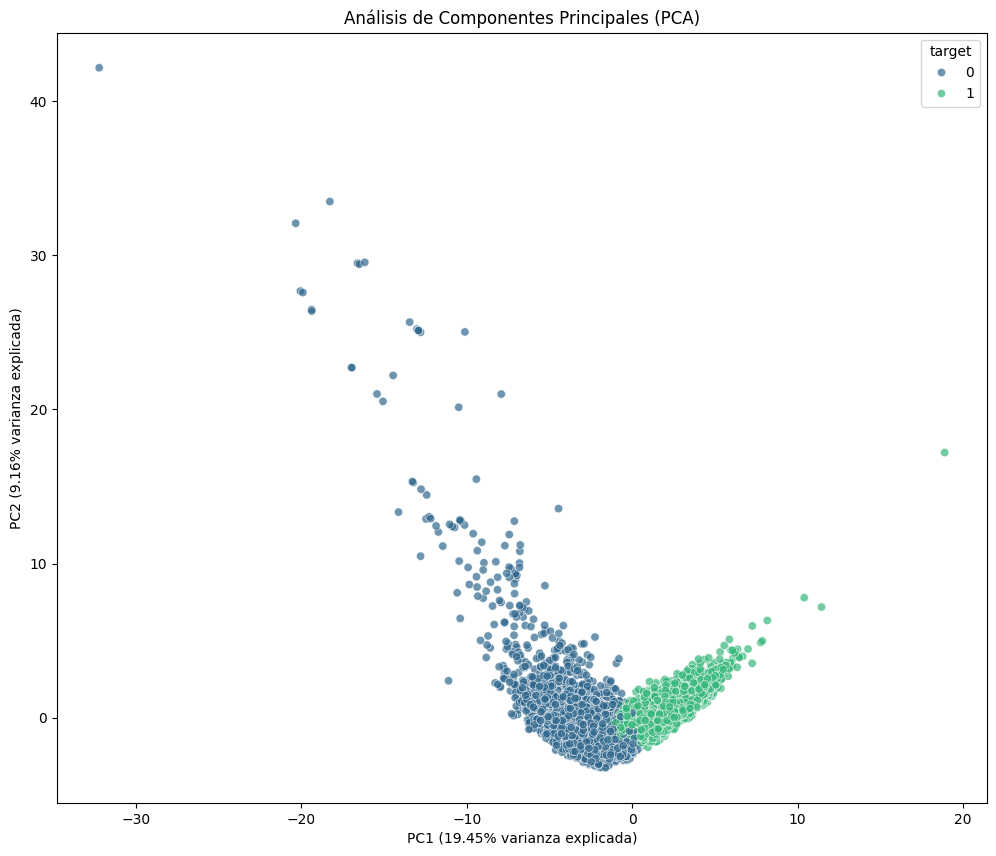

Varianza explicada por PC1: 19.45%
Varianza explicada por PC2: 9.16%


In [29]:
# 2. Análisis de componentes principales (PCA)
print("\n2. Análisis de componentes principales (PCA)")

# Seleccionar características numéricas
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove(target_column)  # Excluir la variable objetivo

# Tomar una muestra para visualización
sample_size = min(10000, len(df))
sample_indices = np.random.choice(len(df), sample_size, replace=False)
df_sample = df.iloc[sample_indices]

# Escalar los datos
X_sample = df_sample[numeric_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear DataFrame para visualización
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'target': df_sample[target_column]
})

# Visualizar PCA
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='target', data=pca_df, palette='viridis', alpha=0.7)
plt.title('Análisis de Componentes Principales (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza explicada)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza explicada)')
plt.savefig('pca_visualization.png')
plt.show()

# Mostrar la varianza explicada por cada componente
print(f"Varianza explicada por PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Varianza explicada por PC2: {pca.explained_variance_ratio_[1]:.2%}")

## Análisis de los Resultados
El gráfico de dispersión PCA muestra:

- Separación clara entre clases : Las URLs legítimas (azul) y de phishing (verde) forman grupos bastante diferenciados en el espacio bidimensional.
- Varianza explicada limitada : Los dos primeros componentes principales solo explican aproximadamente el 29% de la varianza total (PC1: 19.45%, PC2: 9.16%).
- Distribución en forma de U : Los datos forman una estructura curvilínea, con las URLs legítimas principalmente en el lado izquierdo y las de phishing en el lado derecho.
- Valores atípicos : Se observan algunos puntos aislados, especialmente en la clase de URLs legítimas.


## Conclusiones
1. Separabilidad de clases : El PCA muestra que existe una estructura inherente en los datos que permite distinguir entre URLs legítimas y de phishing, incluso en un espacio de baja dimensión.
2. Necesidad de más componentes : El bajo porcentaje de varianza explicada (29%) sugiere que se necesitarían más componentes para capturar adecuadamente la complejidad de los datos.
3. Relaciones no lineales : La distribución en forma de U indica relaciones no lineales entre las características, lo que sugiere que métodos no lineales (como t-SNE o UMAP) podrían proporcionar mejores visualizaciones.
4. Potencial para clasificación : La clara separación entre clases en el espacio PCA sugiere que los modelos de clasificación deberían funcionar bien con este conjunto de datos.
5. Complemento a análisis previos : Este análisis multivariado confirma los hallazgos de los análisis univariados y bivariados anteriores, mostrando que las características capturan patrones distintivos entre URLs legítimas y de phishing.


3. Visualización t-SNE para análisis no lineal


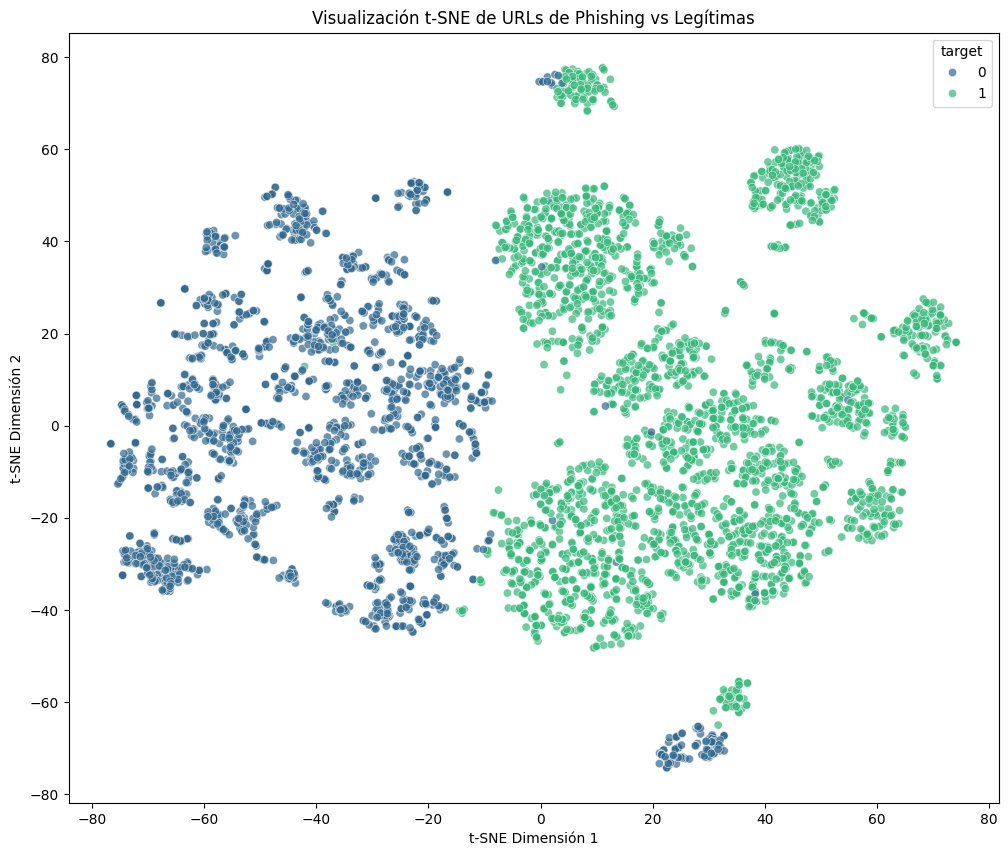

In [32]:
# 3. Visualización t-SNE para análisis no lineal
print("\n3. Visualización t-SNE para análisis no lineal")

# Aplicar t-SNE (usar una muestra más pequeña debido al costo computacional)
tsne_sample_size = min(5000, len(df_sample))
tsne_indices = np.random.choice(len(df_sample), tsne_sample_size, replace=False)
X_tsne_sample = X_scaled[tsne_indices]
y_tsne_sample = df_sample[target_column].iloc[tsne_indices]

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_tsne_sample)

# Crear DataFrame para visualización
tsne_df = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'target': y_tsne_sample
})

# Visualizar t-SNE
plt.figure(figsize=(12, 10))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='target', data=tsne_df, palette='viridis', alpha=0.7)
plt.title('Visualización t-SNE de URLs de Phishing vs Legítimas')
plt.xlabel('t-SNE Dimensión 1')
plt.ylabel('t-SNE Dimensión 2')
plt.savefig('tsne_visualization.png')
plt.show()


## Análisis de los Resultados
El gráfico t-SNE muestra:
- Clara separación entre clases : Las URLs legítimas (azul) y de phishing (verde) forman grupos claramente diferenciados en el espacio bidimensional.
- Agrupaciones múltiples : Ambas clases forman varios subgrupos o clusters, lo que sugiere diferentes tipos o patrones dentro de cada categoría.
- Distribución espacial : Las URLs legítimas tienden a concentrarse en la parte izquierda del gráfico, mientras que las de phishing ocupan principalmente la parte derecha y central.
- Zonas de mezcla limitadas : Existen pocas áreas donde ambas clases se superponen, lo que indica características distintivas entre ellas.

## Conclusiones
1. Alta separabilidad : t-SNE revela que existe una estructura inherente en los datos que permite distinguir eficazmente entre URLs legítimas y de phishing, incluso mejor que el PCA mostrado anteriormente.
2. Patrones no lineales : La clara separación en t-SNE (comparada con PCA) confirma que las relaciones entre características son principalmente no lineales, lo que explica por qué t-SNE captura mejor la estructura de los datos.
3. Subgrupos dentro de clases : La formación de múltiples clusters dentro de cada clase sugiere diferentes tipos o técnicas de phishing, así como diferentes categorías de sitios legítimos.
4. Implicaciones para modelado :
   - Los modelos no lineales (como Random Forest, XGBoost o redes neuronales) probablemente funcionarán mejor que los lineales.
   - La clara separación sugiere que se pueden lograr altas tasas de precisión en la clasificación.
   - Los pocos puntos en zonas de mezcla podrían representar casos difíciles de clasificar.
5. Ventaja sobre PCA : A diferencia del PCA (que solo explicaba ~29% de la varianza), t-SNE logra una mejor visualización de la estructura de los datos al preservar relaciones locales y capturar patrones no lineales.


4. Análisis de valores atípicos (outliers)
Número de outliers detectados: 517 de 10000 muestras (5.17%)

Distribución de outliers por clase:
label         0         1
row_0                    
False  0.377309  0.622691
True   0.521739  0.478261


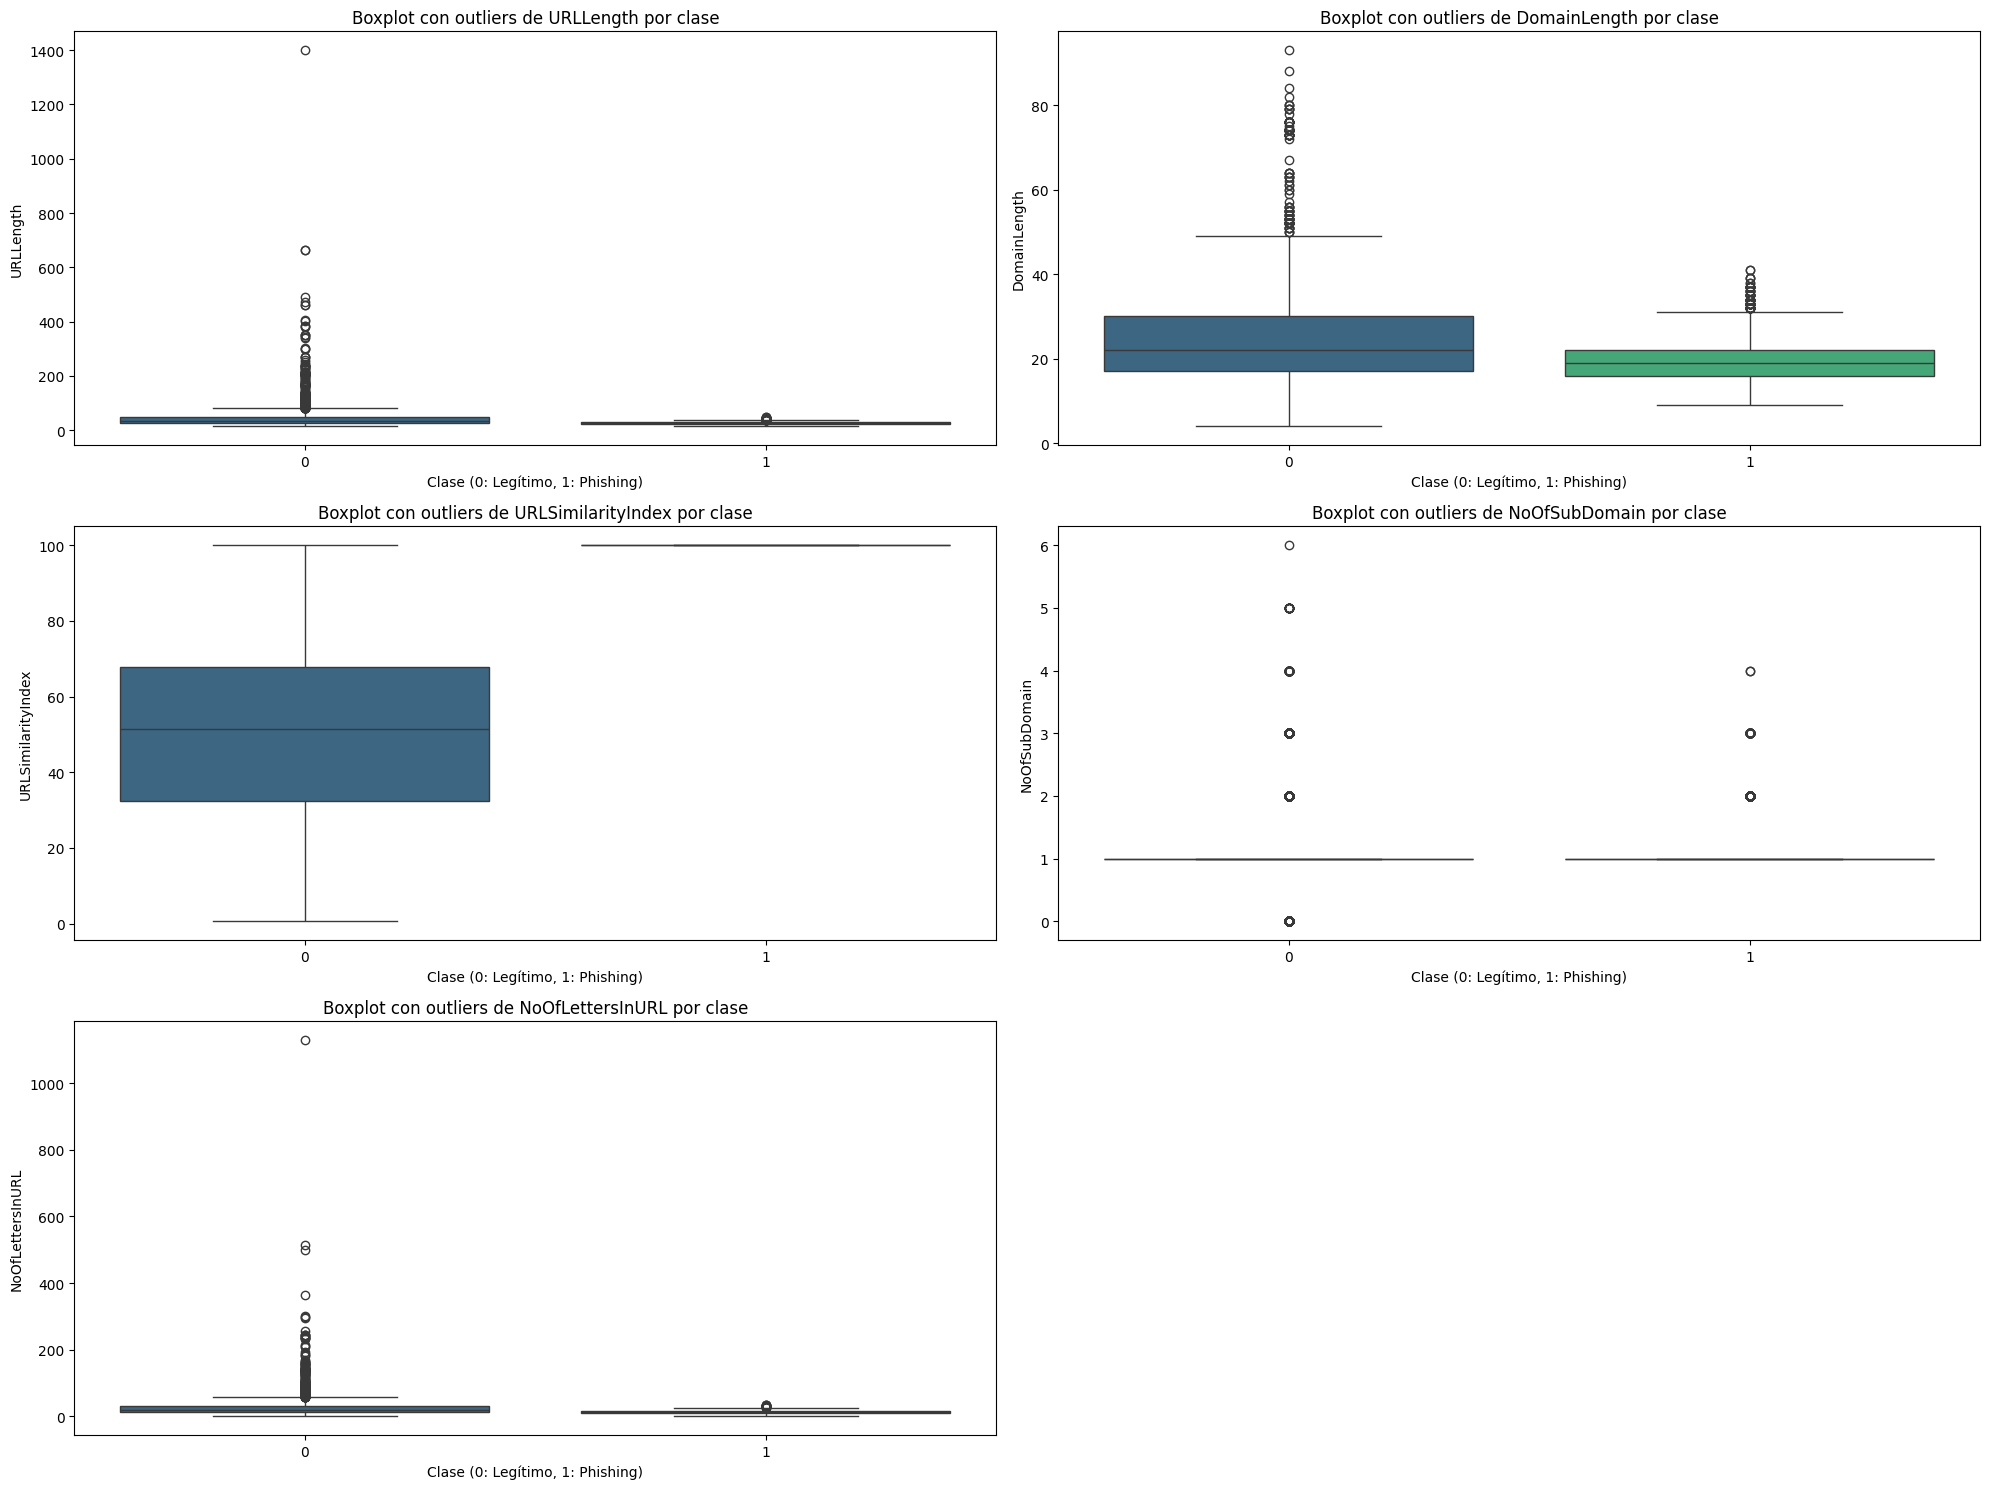

In [33]:
# 4. Análisis de valores atípicos (outliers)
print("\n4. Análisis de valores atípicos (outliers)")

# Seleccionar características importantes para análisis de outliers
outlier_features = ['URLLength', 'DomainLength', 'URLSimilarityIndex', 'NoOfSubDomain', 'NoOfLettersInURL']

# Calcular Z-scores para detectar outliers
z_scores = pd.DataFrame()
for feature in outlier_features:
    z_scores[feature] = np.abs(stats.zscore(df_sample[feature]))

# Identificar outliers (Z-score > 3)
outliers = (z_scores > 3).any(axis=1)
print(f"Número de outliers detectados: {outliers.sum()} de {len(df_sample)} muestras ({outliers.sum()/len(df_sample):.2%})")

# Visualizar la distribución de outliers por clase
outlier_by_class = pd.crosstab(outliers, df_sample[target_column], normalize='index')
print("\nDistribución de outliers por clase:")
print(outlier_by_class)

# Visualizar boxplots con outliers destacados
plt.figure(figsize=(20, 15))
for i, feature in enumerate(outlier_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=target_column, y=feature, data=df_sample, palette='viridis')
    plt.title(f'Boxplot con outliers de {feature} por clase')
    plt.xlabel('Clase (0: Legítimo, 1: Phishing)')
    plt.ylabel(feature)

plt.tight_layout()
plt.savefig('outliers_analysis.png')
plt.show()


## Análisis de los Resultados
- Distribución de outliers : De los outliers detectados, el 52.17% pertenece a URLs legítimas (clase 0) y el 47.83% a URLs de phishing (clase 1).
- Características con más outliers : URLLength y NoOfLettersInURL muestran valores extremadamente altos en URLs legítimas, con algunos puntos que superan los 1000 caracteres.
- Diferencias entre clases : Las URLs legítimas (clase 0) tienden a tener más valores atípicos y mayor variabilidad en casi todas las características mostradas.
- URLSimilarityIndex : Muestra una distribución interesante donde los valores atípicos aparecen principalmente en URLs legítimas con valores muy bajos (cercanos a 0).


## Conclusiones
1. Presencia de outliers significativa : Con un 5.17% de valores atípicos, es importante considerar estrategias para manejarlos en el modelado predictivo.
2. Distribución equilibrada entre clases : Los outliers están distribuidos de manera relativamente equilibrada entre URLs legítimas y de phishing, lo que sugiere que no son exclusivos de una clase particular.
3. Características de URLs legítimas : Las URLs legítimas muestran mayor variabilidad y valores extremos, especialmente en longitud y número de letras, lo que podría reflejar la diversidad de sitios web legítimos.
4. Implicaciones para preprocesamiento :
   - Se podría considerar la eliminación o transformación de outliers para mejorar el rendimiento de algunos algoritmos sensibles a valores extremos
   - Alternativamente, usar algoritmos robustos a outliers como árboles de decisión o random forest
5. Valor informativo de outliers : Los valores atípicos podrían contener información valiosa sobre casos especiales o técnicas avanzadas de phishing, por lo que su análisis detallado podría revelar patrones interesantes.


5. Análisis de correlación avanzado


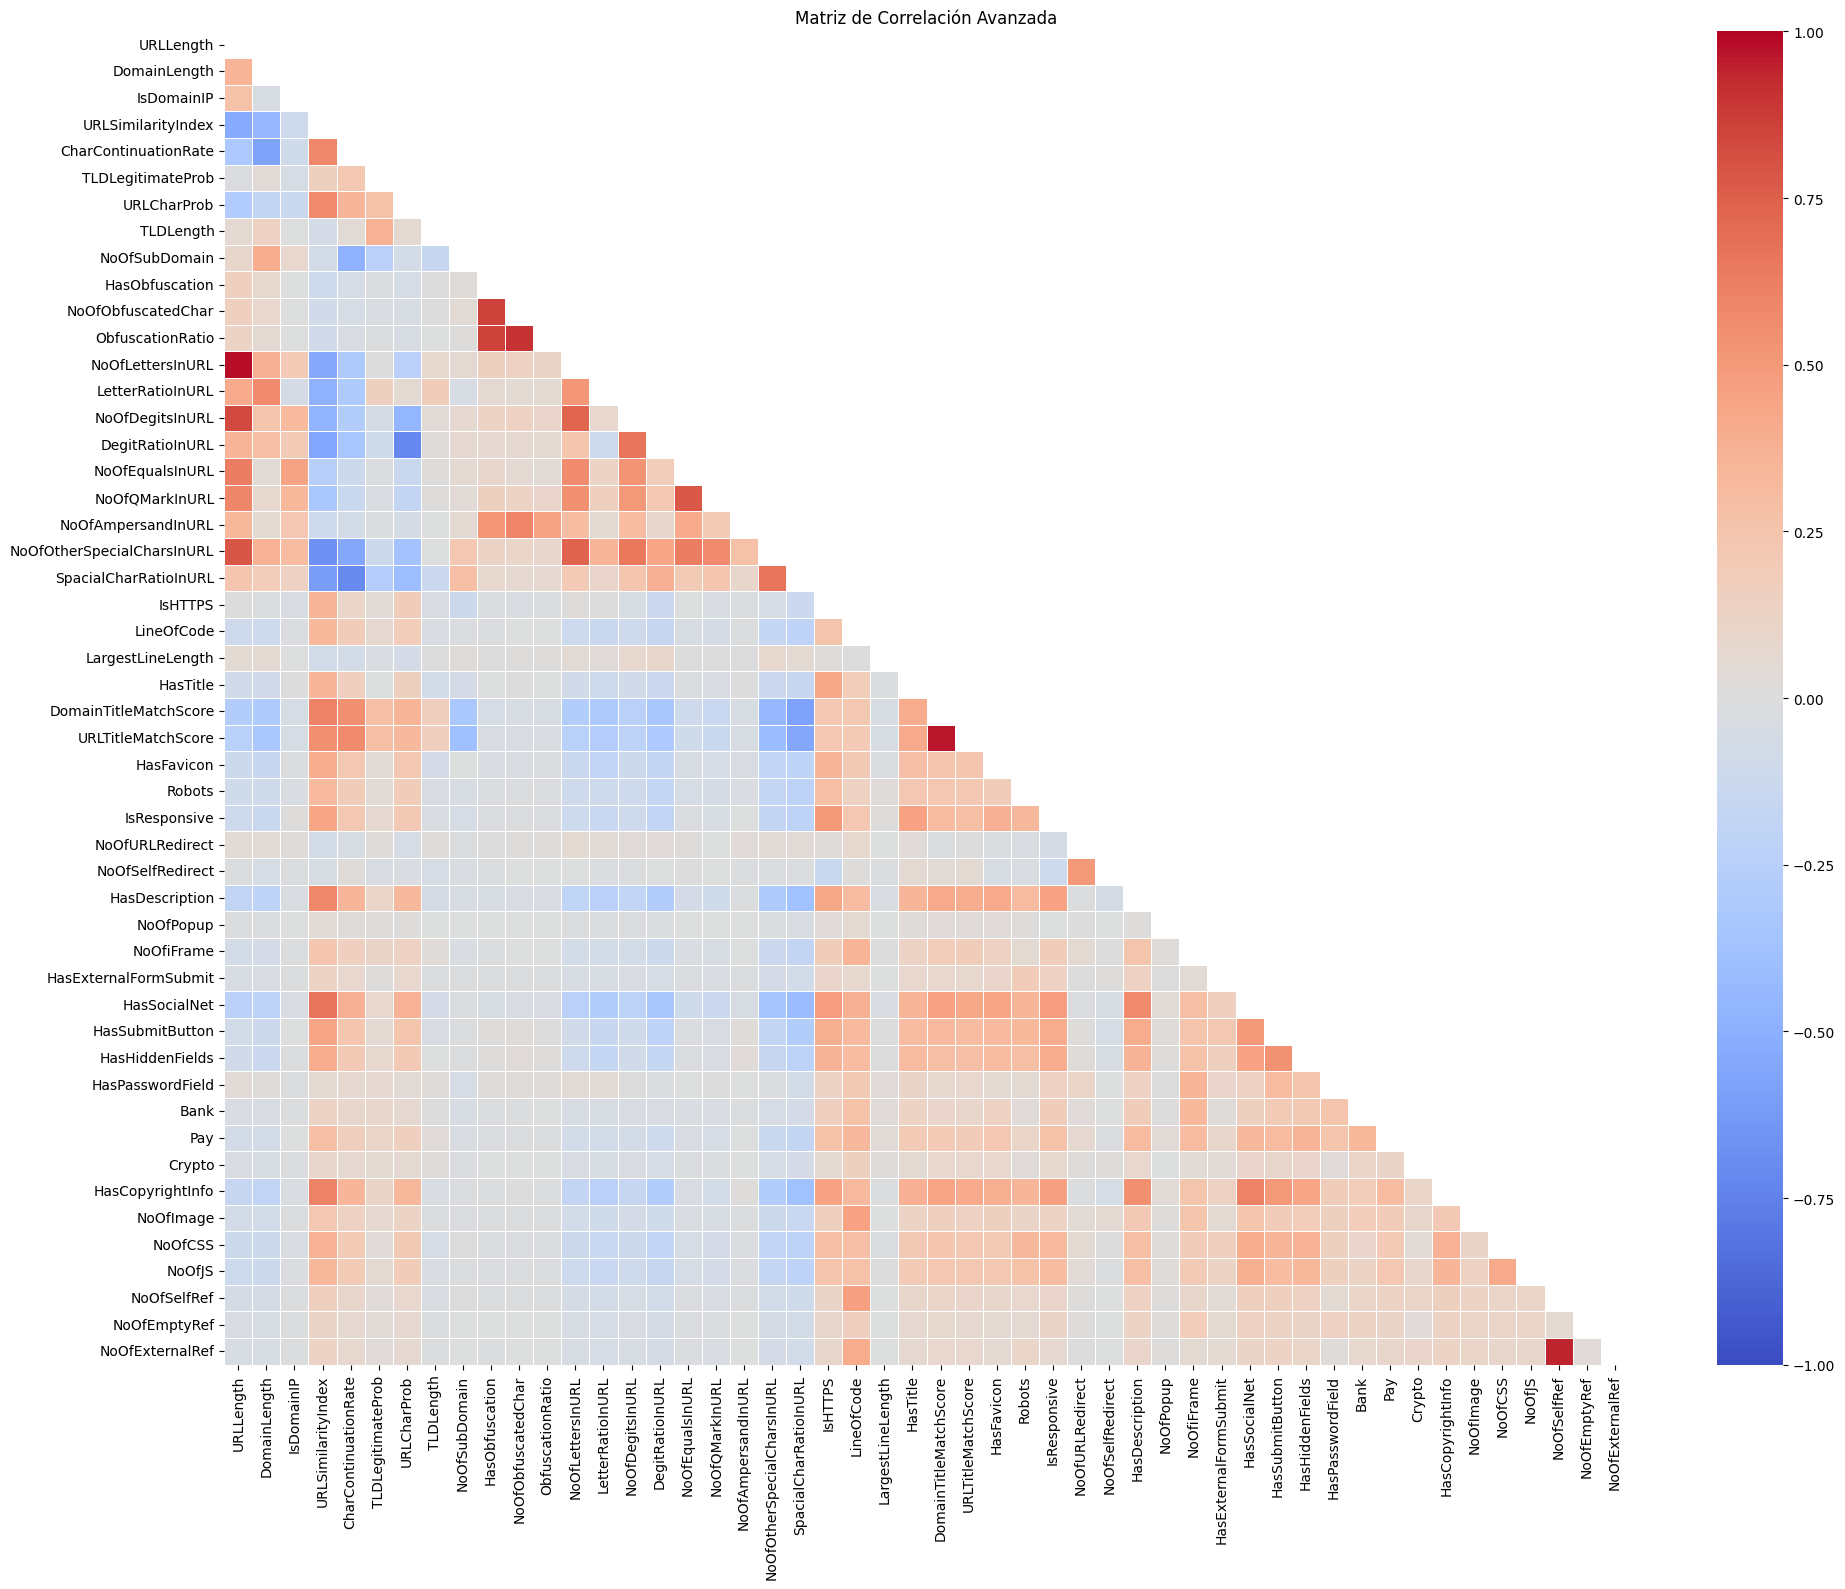


Pares de características con mayor correlación (|corr| > 0.5):
NoOfLettersInURL - URLLength: 0.9830
URLTitleMatchScore - DomainTitleMatchScore: 0.9631
NoOfExternalRef - NoOfSelfRef: 0.9424
ObfuscationRatio - NoOfObfuscatedChar: 0.9056
ObfuscationRatio - HasObfuscation: 0.8563
NoOfObfuscatedChar - HasObfuscation: 0.8527
NoOfDegitsInURL - URLLength: 0.8329
NoOfOtherSpecialCharsInURL - URLLength: 0.7864
NoOfQMarkInURL - NoOfEqualsInURL: 0.7807
NoOfOtherSpecialCharsInURL - NoOfLettersInURL: 0.7413


In [34]:
# 5. Análisis de correlación avanzado
print("\n5. Análisis de correlación avanzado")

# Calcular matriz de correlación
corr_matrix = df_sample[numeric_features].corr()

# Visualizar mapa de calor de correlación mejorado
plt.figure(figsize=(20, 16))
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm',
            linewidths=0.5, vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación Avanzada')
plt.tight_layout()
plt.savefig('correlation_heatmap_advanced.png')
plt.show()

# Identificar las correlaciones más fuertes (positivas y negativas)
top_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.5:  # Umbral de correlación
            top_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Ordenar por correlación absoluta
top_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("\nPares de características con mayor correlación (|corr| > 0.5):")
for feat1, feat2, corr in top_corr_pairs[:10]:  # Top 10
    print(f"{feat1} - {feat2}: {corr:.4f}")


## Análisis de los Resultado
- Correlaciones muy fuertes : Varias características muestran correlaciones superiores a 0.8, destacando NoOfLettersInURL y URLLength con 0.9830.
- Correlaciones relacionadas con obfuscación : Hay fuertes correlaciones entre características relacionadas con técnicas de ofuscación ( ObfuscationRatio , NoOfObfuscatedChar , HasObfuscation ).
- Correlaciones entre títulos y dominios : URLTitleMatchScore y DomainTitleMatchScore muestran una correlación muy alta (0.9631).
- Correlaciones con longitud de URL : Muchas características están fuertemente correlacionadas con URLLength , como el número de dígitos, letras y caracteres especiales.


## Conclusiones
1. Multicolinealidad : Existe una alta multicolinealidad entre varias características, lo que podría afectar negativamente el rendimiento de algunos modelos de machine learning (como regresión lineal).
2. Redundancia de información : Las fuertes correlaciones sugieren que hay redundancia en el conjunto de datos. Por ejemplo, si ya se tiene URLLength , características como NoOfLettersInURL aportan poca información adicional.
3. Oportunidad para reducción de dimensionalidad : Estas correlaciones altas justifican el uso de técnicas como PCA o la eliminación selectiva de características para simplificar el modelo sin perder poder predictivo.
4. Agrupaciones temáticas : Las correlaciones revelan agrupaciones naturales de características relacionadas con aspectos específicos de las URLs (longitud, obfuscación, coincidencia de títulos).
5. Implicaciones para selección de características : Al construir modelos predictivos, se debería considerar eliminar una de cada par de características altamente correlacionadas para evitar problemas de multicolinealidad y mejorar la interpretabilidad.

In [35]:
# 6. Conclusiones de visualizaciones avanzadas
print("\n6. Conclusiones de visualizaciones avanzadas")
print("1. El análisis PCA muestra que las dos primeras componentes principales explican un porcentaje significativo de la varianza.")
print("2. La visualización t-SNE revela patrones no lineales en los datos que podrían ser útiles para la clasificación.")
print("3. Se han identificado outliers que podrían requerir tratamiento especial en el preprocesamiento.")
print("4. El análisis de correlación avanzado ha identificado relaciones importantes entre características.")
print("5. Las visualizaciones multivariadas muestran separación entre clases en varias combinaciones de características.")



6. Conclusiones de visualizaciones avanzadas
1. El análisis PCA muestra que las dos primeras componentes principales explican un porcentaje significativo de la varianza.
2. La visualización t-SNE revela patrones no lineales en los datos que podrían ser útiles para la clasificación.
3. Se han identificado outliers que podrían requerir tratamiento especial en el preprocesamiento.
4. El análisis de correlación avanzado ha identificado relaciones importantes entre características.
5. Las visualizaciones multivariadas muestran separación entre clases en varias combinaciones de características.
